In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [4]:
from scipy.io import loadmat
# Model / data parameters
train_raw = loadmat('./data/svhn/train_32x32.mat')
test_raw = loadmat('./data/svhn/test_32x32.mat')
# Load images and labels
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

# Model / data parameters
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
# (x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(train_labels, num_classes)
# y_test = keras.utils.to_categorical(test_labels, num_classes)
train_ds_svhn = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds_svhn = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
train_ds_svhn = (train_ds_svhn
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds_svhn = (test_ds_svhn
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds_svhn)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


In [5]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


In [6]:

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl


def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)



def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost




In [7]:
from scipy.special import logsumexp

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(p,alpha)
        return (A + B) + C
    return custom_loss_function


# def MAEBM(lambda_callback: lambda_update):
#     import tensorflow_probability as tfp
#     def MAEBM_loss(labels, outputs):
#         n_classes=10
#         evidence = exp_evidence(outputs)
#         alpha = evidence + 1
#         soft_output= labels
#         S = tf.reduce_sum(alpha,axis=1,keepdims=True)
#         alpha_0 = S * tf.ones((outputs.shape[-1]))
#         UCE_loss = tf.reduce_mean(
#             tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
#         )
#         annealing_coef =  lambda_callback.lambda_t
#         dirichlet_weight = 0.1 * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
#         UCE_loss = (
#             UCE_loss + dirichlet_weight
#         )
#         return UCE_loss
#     return MAEBM_loss



def cross_energy(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        annealing_rate =  lambda_callback.lambda_t
        # beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
        # C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        
        Ec_in = -tf.math.reduce_logsumexp(outputs)
        # Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
        # tf.print(0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)))
        # energy_loss = 0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)) #+ torch.pow(F.relu(args.m_out-Ec_out), 2).mean()) OLD METHOD< DID WORSE THEN ENERGY on EDL
        
        #so what about EDL + energy? 
        # val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        # sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        energy_loss = annealing_rate * (tf.math.log(evidence)/tf.math.log(tf.constant(2, dtype=evidence.dtype)))
        
        # return loss + energy_loss #+  C
        return (A + B) + energy_loss 
    return  cross_entropy_evidence

import tensorflow_probability as tfp

def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        # evidence = tf.exp(logits)
        evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    return  brevisEnergy


In [15]:
# ### from scratch model


# import random
# seed = 42
# random.seed(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)
# # model.save('./models/cifaroutlier_EDL_adam.hdf5')
# lambda_callback = lambda_update(10000,0,max_t = 0.01)
# # loss = kl_loss(lambda_callback)
# loss = brevisEnergy(lambda_callback)
# # loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# # model = keras.models.load_model("./models/cifaroutlier_EDL_adam.hdf5",custom_objects={"custom_loss_function":loss})
# model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
# model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#               # tf.keras.optimizers.Adam(),
#               # tf.optimizers.SGD(lr=0.001, momentum=0.9)
#               loss=loss,
#               metrics=['accuracy'])

# history = model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])
# model.evaluate(test_ds)
# #CE test results [1.179532766342163, 0.6154000163078308]
# #MAEB 20epochs [0.3198821544647217, 0.6216999888420105]
# #MAEB 26epochs, no dirichlet [0.13894104957580566, 0.6498000025749207]

In [16]:
# model.save('./models/cifaroutlier_EDL_RKL.hdf5')
# model = tf.keras.models.load_model('./models/cifaroutlier_EDL_adam.hdf5',custom_objects={"custom_loss_function":loss_wrapper(lambda_callback),"entropy":entropyMetric()})

In [18]:
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

In [19]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], optimizer="adam", preset="", metrics=['accuracy'])



Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000002310C9950C8>

preset: Other


In [17]:
# model.save("./models/journal_models/alexnet_B_conv3_5.h5")

In [20]:
model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 92s 60ms/step - loss: 2.3406 - classification_loss: 0.2322 - branch_exit_loss: 1.0621 - branch_exit_1_loss: 1.0462 - classification_accuracy: 0.9247 - branch_exit_accuracy: 0.6307 - branch_exit_1_accuracy: 0.6395 - val_loss: 3.8231 - val_classification_loss: 0.9900 - val_branch_exit_loss: 1.4474 - val_branch_exit_1_loss: 1.3857 - val_classification_accuracy: 0.7406 - val_branch_exit_accuracy: 0.5402 - val_branch_exit_1_accuracy: 0.5740
annealing coef updated to: 0.001
Epoch 2/10
1407/1407 [==============================] - 83s 59ms/step - loss: 1.7898 - classification_loss: 0.2449 - branch_exit_loss: 0.7818 - branch_exit_1_loss: 0.7632 - classification_accuracy: 0.9207 - branch_exit_accuracy: 0.7295 - branch_exit_1_accuracy: 0.7410 - val_loss: 2.5667 - val_classification_loss: 0.8690 - val_branch_exit_loss: 0.9117 - val_branch_exit_1_loss: 0.7859 

KeyboardInterrupt: 

In [21]:
model.evaluate(test_ds)

313/313 [==============================] - 5s 17ms/step - loss: 2.9937 - classification_loss: 0.9799 - branch_exit_loss: 1.1953 - branch_exit_1_loss: 0.8185 - classification_accuracy: 0.7727 - branch_exit_accuracy: 0.6966 - branch_exit_1_accuracy: 0.7441


[2.9937329292297363,
 0.979895293712616,
 1.1953325271606445,
 0.8185047507286072,
 0.7727000117301941,
 0.6966000199317932,
 0.7440999746322632]

In [11]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 19ms/step - loss: 3.1703 - classification_loss: 1.1872 - branch_exit_loss: 1.2301 - branch_exit_1_loss: 0.7530 - classification_accuracy: 0.7376 - branch_exit_accuracy: 0.7106 - branch_exit_1_accuracy: 0.7672


[3.170335292816162,
 1.1871545314788818,
 1.2301453351974487,
 0.7530348896980286,
 0.7376000285148621,
 0.7106000185012817,
 0.7671999931335449]

In [ ]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_2").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

In [22]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
model.save("./models/journal_models/resnet_CE_branched.hdf5")
# model = tf.keras.models.load_model("./models/journal_models/resnet_CE_entropy_finetuned.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy(lambda_callback)})

In [16]:
model.evaluate(test_ds)

313/313 [==============================] - 5s 13ms/step - loss: 0.8078 - accuracy: 0.7815


[0.8078321218490601, 0.781499981880188]

In [29]:
# output_ID_test= evaluate.getPredictions_Energy(model, test_ds,stopping_point=1)
# # for i in output_ID:
#     # i['outlier']=0

prediction: 1 of 313


In [24]:
output_ID= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3


In [23]:
output_OOD = evaluate.getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3


In [ ]:
# output_OOD_svhn = getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
# output_OOD_svhn['correct']=0
# output_OOD_svhn['outlier']=1


In [15]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'resnet_CE_entropy_finetuned.hdf5'
save_outputs(filename+'_ID',output_ID)
save_outputs(filename+'_OOD',output_OOD)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

In [35]:
def load_outputs(filename,exits=['exit1','exit2','exit3']):
    result = list(pd.read_excel("./csv/"+filename,sheet_name=exits).values())
    return result

# output_ID = pd.read_excel("./csv/alexnet_B_conv3_5_test.h5_ID.xlsx",sheet_name=exits)
# output_OOD = pd.read_excel("./csv/alexnet_B_conv3_5_test.h5_OOD.xlsx",sheet_name=['exit1','exit2','exit3'])

output_ID = load_outputs("resnet_B_Bconv3_10_ID.xlsx",exits =['exit1','exit2','exit3'])

output_OOD = load_outputs("resnet_B_Bconv3_10_OOD.xlsx",exits =['exit1','exit2','exit3'])

In [36]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

from matplotlib import pyplot
def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds




metric:  entropy threshold:  gmean
entropy  lr_auc 0.19027552320707927 Best Threshold=0.42808103561401367, G-Mean=0.7356662601795074, TPR=0.7920237310481213, FPR=0.3166810221073787
['exit_1', 'exit_2']
5392 inputs accepted 4760 Correct


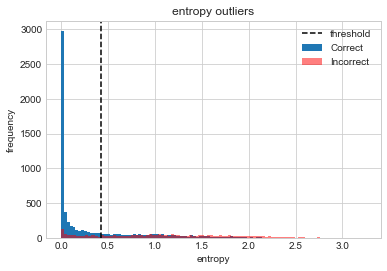

-----------------
entropy  lr_auc 0.1699052213218914 Best Threshold=0.8975710868835449, G-Mean=0.7558685713784975, TPR=0.7835091832747166, FPR=0.27079693589571296
rollover enabled, 4608 predictions provided
['exit_1', 'exit_2']
1660 inputs accepted 1330 Correct


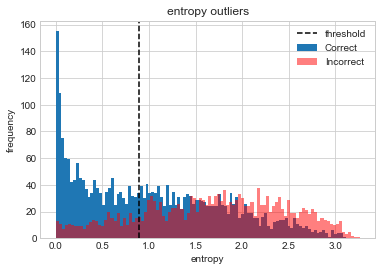

-----------------
entropy  lr_auc 0.15841498528394532 Best Threshold=3.2219419479370117, G-Mean=0.7757788737403815, TPR=0.8178618565772108, FPR=0.26413873430826973
rollover enabled, 2948 predictions provided
main_exit
2948 inputs accepted 1597 Correct


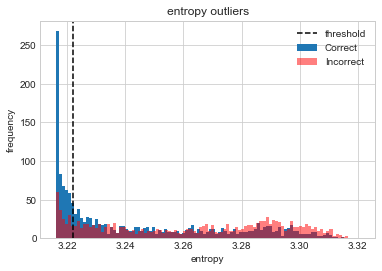

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6966           0.696600   0.428081      5392              4760        0.539200             0.882789
1     exit_2         4608         0.7441           0.590712   0.897571      1660              1330        0.360243             0.801205
2  Main_exit         2948         0.7727           0.541723   3.221942      2948              1597        1.000000             0.541723


In [26]:
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=True)

In [25]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6966           0.696600   0.027730      3035              2920        0.303500             0.962109
1     exit_2         6965         0.7441           0.653123   0.048205       678               648        0.097344             0.955752
2  Main_exit         6287         0.7727           0.662160   3.320557      6287              4163        1.000000             0.662160
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6966           0.696600   0.409462      5327              4708        0.532700             0.883800
1     exit_2         4673         0.7441

In [34]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy     Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6186           0.618600  3.954638e-10      3815              3254        0.381500             0.852949
1     exit_2         6185         0.6842           0.585610  3.957630e-20      1131              1036        0.182862             0.916004
2  Main_exit         5054         0.7229           0.573803  3.224054e+00      5054              2900        1.000000             0.573803
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6186           0.618600   0.051048      8170              5538        0.817000             0.677846
1     exit_2      

metric:  entropy threshold:  gmean
entropy  lr_auc 0.19027552320707927 Best Threshold=0.42808103561401367, G-Mean=0.7356662601795074, TPR=0.7920237310481213, FPR=0.3166810221073787


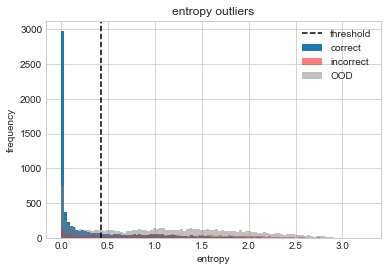

['exit_1']
entropy  lr_auc 0.1699052213218914 Best Threshold=0.8975710868835449, G-Mean=0.7558685713784975, TPR=0.7835091832747166, FPR=0.27079693589571296


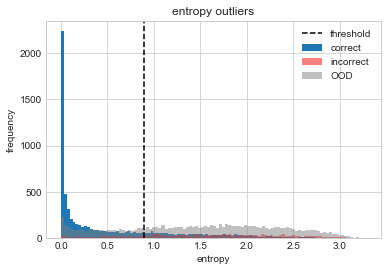

['exit_1', 'exit_2']
entropy  lr_auc 0.15841498528394532 Best Threshold=3.2219419479370117, G-Mean=0.7757788737403815, TPR=0.8178618565772108, FPR=0.26413873430826973


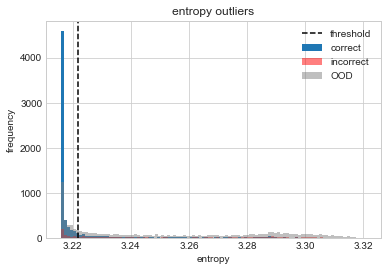

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6966  0.428081         5392          2517              4760           0.681755             0.601846
1     exit_2       4608        7483         0.7441  0.897571         1660          1534              1330           0.519724             0.416406
2  Main_exit       2948        5949         0.7727        NA         2948          5949              1597           0.331348             0.179499


In [27]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)

# evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

metric:  uncert
4084 inputs accepted 3284 Correct


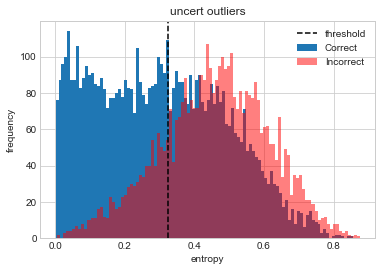

-----------------
rollover enabled, 5916 predictions provided
534 inputs accepted 500 Correct


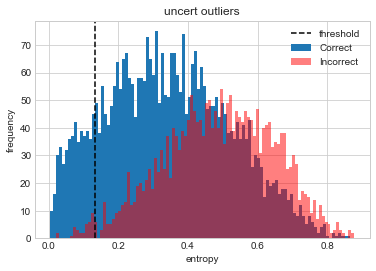

-----------------
rollover enabled, 5382 predictions provided
main_exit
5382 inputs accepted 3859 Correct


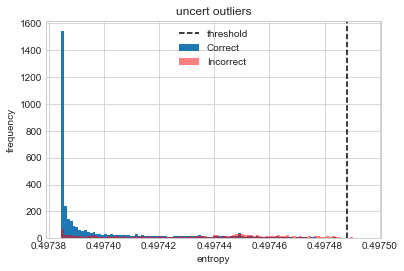

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy         Flops
0   branch1        10000         0.5917           0.591700   0.323077      4084              3284        0.408400             0.804114   71238314680
1   branch2         5916         0.7139           0.613083   0.134503       534               500        0.090264             0.936330   15710132616
2      main         5382         0.8091           0.717020   0.497488      5382              3859        1.000000             0.717020  711145311786
thresholds [0.32307744, 0.1345032, 0.4974882]
input_predictions [10000, 5916, 5382]
Accepted_list [4084, 534, 5382]
Acceptance_correct [3284, 500, 3859]
overall Accuracy 0.7643
branch_cost [71238314680, 15710132616, 711145311786]
base cost:  798093759082  total cost: 1126988380000
cost difference:  0.7081650292454656


In [34]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["uncert"],plot=)

#### Calibration Results

metric:  calibration threshold:  gmean
calibration  lr_auc 0.8098855378350558 Best Threshold=0.937641441822052, G-Mean=0.7340146967733912, TPR=0.6726959517657192, FPR=0.1990771259063942


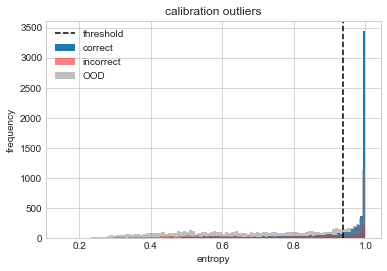

['exit_1', 'exit_2']
calibration  lr_auc 0.8334738420816112 Best Threshold=0.8306676745414734, G-Mean=0.7569981469438327, TPR=0.7206020696142992, FPR=0.20476748729972646


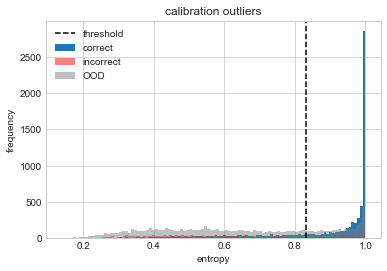

['exit_1', 'exit_2']
calibration  lr_auc 0.8415065279522481 Best Threshold=0.2278103083372116, G-Mean=0.7757788737403813, TPR=0.7358612656917303, FPR=0.18213814342278928


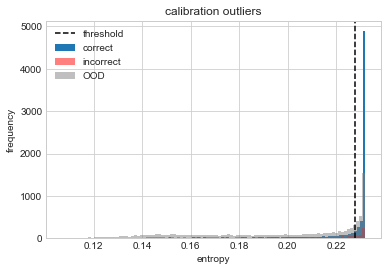

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6966  0.937641         5290          2459              4686           0.682669             0.604723
1     exit_2       4710        7541         0.7441  0.830668         1695          1611              1369           0.512704             0.414096
2  Main_exit       3015        5930         0.7727        NA         3015          5930              1638           0.337060             0.183119


In [28]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",plot=True)

# evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

In [26]:
import math
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        AUC_thresholds = calc_AUC(output_ID, metrics=metrics,plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct +accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":["branch1","branch2","main"],
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))

In [ ]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "PR_AUC",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

In [16]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "PR_AUC",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  energy threshold:  PR_AUC
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7106 -13.024596         2895           444              2781           0.867026             0.832884
1     exit_2       7105        9556         0.7672  -9.275606          812           234               764           0.776291             0.730402
2  Main_exit       6293        9322         0.7376         NA         6293          9322              3949           0.403010             0.252898


In [138]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

from matplotlib import pyplot
# metrics = ['energy','entropy_of_expected']
def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds

def buildCompareDistribPlot(ID,OOD=None,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        AUC_thresholds = calc_AUC(ID, metrics=metrics,plot = True)
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            # _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            legend = ["threshold","correct","incorrect", "OOD"]
            Correct = ID.loc[(ID['correct'] == True)]
            Incorrect = ID.loc[(ID['correct'] == False)]
            _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
            if OOD is None:
                OOD = pd.DataFrame(columns=ID.columns)
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            
            
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    # _threshold = np.array(ID[metric]).mean()
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    _threshold = AUC_thresholds[i]
                    # _threshold = np.array(ID[metric]).mean()
                    # fpr, tpr, thresholds = roc_curve(np.int32(ID['correct']), ID[metric],pos_label=0)
                    # gmeans = sqrt(tpr * (1-fpr))
                    # ix = argmax(gmeans)
                    # _threshold = thresholds[ix]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(ID['correct'], ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric + " outliers")
                plt.legend(legend)
                plt.xlabel("entropy")
                plt.ylabel("frequency")
                plt.show()
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = OOD.loc[(OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = OOD.loc[(OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = ID.loc[(ID[metric] <= _threshold)] #TP
                    ID_rejected = ID.loc[(ID[metric] > _threshold)] #FN
                    
                    
                    accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
                    rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN
                    
                    accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
                    rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
                    
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                    print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                    print("overall Accepted acc:",(overall_accepted_acc))
                    
                    # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                    # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                    # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                else: ### metrics that require greater than metric
                    OOD_accepted = OOD.loc[(OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = OOD.loc[(OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = ID.loc[(ID[metric] >= _threshold)] #TP
                    ID_rejected = ID.loc[(ID[metric] < _threshold)] #FN
                    
                    accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
                    rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN
                    
                    accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
                    rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
                    
                    
                    
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                    print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                    print("overall Accepted acc:",(overall_accepted_acc))
                    
                    # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                    # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                    # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                
                print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                if len(OOD) > 0:
                    print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                else: 
                    print("FPR for OOD is div by zero, was OOD included?")
                print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))

energy  lr_auc 0.4420954222816514 Best Threshold=0.6266776323318481, G-Mean=0.5392735832037918, TPR=0.5870374968959523, FPR=0.5046040515653776
uncert  lr_auc 0.6111945439769917 Best Threshold=0.6424882411956787, G-Mean=0.4214332071208849, TPR=0.4315867891730817, FPR=0.58848150008371
entropy  lr_auc 0.23908319995230584 Best Threshold=1.1779698133468628, G-Mean=0.6944930195760037, TPR=0.7442264713185994, FPR=0.3519169596517663
calibration  lr_auc 0.767563131018646 Best Threshold=0.6875507235527039, G-Mean=0.7005592552981639, TPR=0.6845806127574083, FPR=0.28308914824931714


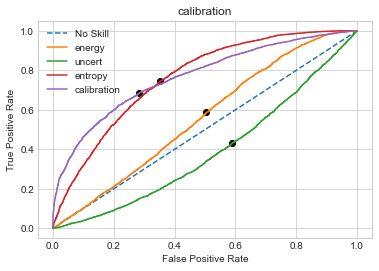

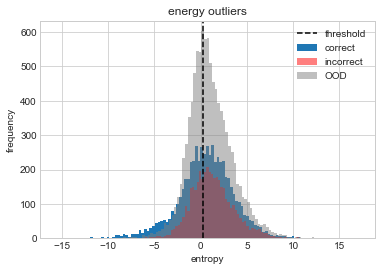

OOD accepted: 3935 : with threshold: 0.2630725
ID accepted: 4028 :with acc: 0.6519364448857994
overall Accepted acc: 0.32977521034785884
TPR_ID-OOD 0.4028
TPR_acc 0.43964506947932364
FPR_ID-OOD 0.3935
FPR_acc 0.3481499875838093


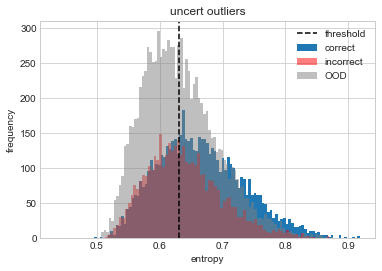

OOD accepted: 5368 : with threshold: 0.6314874
ID accepted: 4028 :with acc: 0.5034756703078451
overall Accepted acc: 0.21583652618135377
TPR_ID-OOD 0.4028
TPR_acc 0.33952787543947766
FPR_ID-OOD 0.5368
FPR_acc 0.4966476285075739


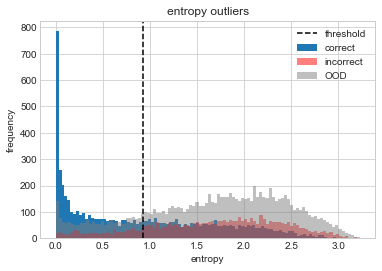

OOD accepted: 1908 : with threshold: 0.92764586
ID accepted: 4028 :with acc: 0.8331678252234359
overall Accepted acc: 0.5653638814016172
TPR_ID-OOD 0.4028
TPR_acc 0.5618617110329818
FPR_ID-OOD 0.1908
FPR_acc 0.16687360317854483


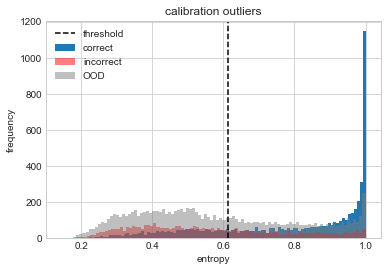

OOD accepted: 4024 : with threshold: 0.61402047
ID accepted: 5973 :with acc: 0.7461911937050059
overall Accepted acc: 0.4458337501250375
TPR_ID-OOD 0.5973
TPR_acc 0.7461911937050059
FPR_ID-OOD 0.4024
FPR_acc 0.376458902408741


In [ ]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "PR_AUC")

energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525
uncert  lr_auc 0.31638608086275255 Best Threshold=0.1802276074886322, G-Mean=0.62938448550687, TPR=0.6555429864253394, FPR=0.39573019801980197
entropy  lr_auc 0.2374392213330496 Best Threshold=0.00043300143443048, G-Mean=0.7017048641576846, TPR=0.7774321266968326, FPR=0.3666460396039604
calibration  lr_auc 0.7540569278930156 Best Threshold=0.9999741315841675, G-Mean=0.7015787824510725, TPR=0.6338180693069307, FPR=0.2234162895927602


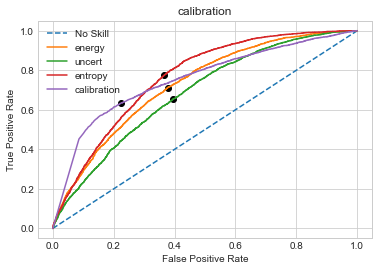

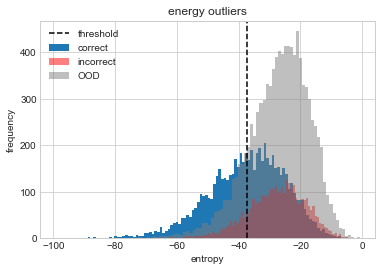

OOD accepted: 1480 : with threshold: -37.3288
ID accepted: 3575 :with acc: 0.8475524475524475
overall Accepted acc: 0.599406528189911
TPR_ID-OOD 0.3575
TPR_acc 0.46875
FPR_ID-OOD 0.148
FPR_acc 0.1541289592760181


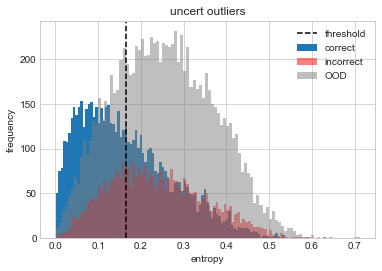

OOD accepted: 2543 : with threshold: 0.16586734
ID accepted: 4690 :with acc: 0.7742004264392324
overall Accepted acc: 0.5020047006774506
TPR_ID-OOD 0.469
TPR_acc 0.5617264851485149
FPR_ID-OOD 0.2543
FPR_acc 0.29949095022624433


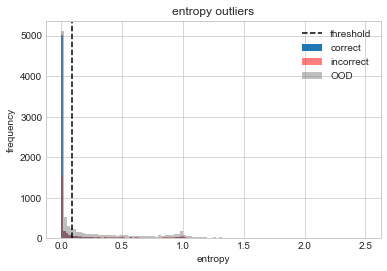

OOD accepted: 6098 : with threshold: 0.08850501
ID accepted: 7418 :with acc: 0.7314640064707468
overall Accepted acc: 0.4014501331754957
TPR_ID-OOD 0.7418
TPR_acc 0.8394183168316832
FPR_ID-OOD 0.6098
FPR_acc 0.5633484162895928


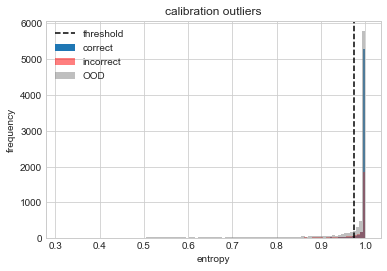

OOD accepted: 6723 : with threshold: 0.9752796
ID accepted: 7869 :with acc: 0.7158469945355191
overall Accepted acc: 0.3860334429824561
TPR_ID-OOD 0.7869
TPR_acc 0.8714418316831684
FPR_ID-OOD 0.6723
FPR_acc 0.6323529411764706


In [112]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

In [71]:
def combineThresholds(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        # if type(metrics ) is not list:
        #     metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")
        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID.loc[(ID[metric].tolist() <= energy_threshold)]
        _OOD = OOD.loc[(OOD[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold
        metric = 'energy'
        print("metric", metric)
        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((output_ID.loc[output_ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        _OOD_accepted = _OOD.loc[(_OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(_OOD_accepted))
        _ID_accepted = _ID.loc[(_ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(_ID_accepted))
        print("ID acc", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted))
        print("overall Acc (ID+OOD)", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]
        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", energy_threshold, ",", len(_OOD), ",", len(_ID),",",
                                                       len(_ID.loc[_ID['correct']==True])/len(_ID),",",
                                                       correct_threshold, ",",len(_OOD_accepted),",",
                                                       len(_ID_accepted),",", ",",
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted),',',
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
# combineThresholds(output_ID,output_OOD, metrics = ['energy'], excel=True)



def combineThresholds2(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        if type(metrics ) is not list:
            metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")

        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((ID.loc[ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        OOD_accepted = OOD.loc[(OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(OOD_accepted))
        ID_accepted = ID.loc[(ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(ID_accepted))
        print("ID acc", len(ID_accepted.loc[ID_accepted['correct'] == True])/len(ID_accepted))
        print("overall Acc (ID+OOD)", len(ID_accepted.loc[ID_accepted['correct'] == True])/(len(ID_accepted)+len(OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]


        metric  = 'energy'
        print("metric", metric)

        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID_accepted.loc[(ID_accepted[metric].tolist() <= energy_threshold)]
        _OOD = OOD_accepted.loc[(OOD_accepted[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold

        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", correct_threshold, ",", len(OOD_accepted), ",", len(ID_accepted),",",
                                                       len(ID_accepted.loc[ID_accepted['correct']==True])/len(ID_accepted),",",
                                                       energy_threshold, ",",len(_OOD),",",
                                                       len(_ID),",", ",",
                                                       len(_ID.loc[_ID['correct'] == True])/len(_ID),',',
                                                       len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
combineThresholds2(output_ID,output_OOD, metrics = ['energy'], excel=True)

 # df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})

------ energy --------
threshold -49.350967
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
metric energy
-35.580128
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
energy , -49.350967 , 820 , 2952 , 0.9258130081300813 , -35.580128 , 820 , 2952 , , 0.9258130081300813 , 0.7245493107104984


In [36]:
###find 95% TPR
def buildTPR(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _max =  np.array(ID[metric]).max()
            _min =  np.array(ID[metric]).min()
            linrange = np.linspace(_min, _max,100)
            print(len(linrange))
            total_correct = ID.loc[ID['correct'] == True]
            print(len(total_correct))
            # TP_qualifier = round(len(total_correct)*.95)
            TP_qualifier = round(len(ID)*.95)
            print("TP_qual",TP_qualifier)
            for point in linrange:
                # print(point)
                #get ID below this amount
                # TP = ID.loc[(ID[metric]<=point) & ID['correct'] == True]
                TP = ID.loc[(ID[metric]<=point) ]#& ID['correct'] == True]
                if len(TP) >=TP_qualifier:
                    FP = OOD.loc[(OOD[metric]<=point)]
                    print(point, "ID:", len(TP)," OOD:",len(FP))
            
            _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            # if threshold:
            #     if type(threshold) is list:
            #         if i >= len(threshold): #no threshold in the array so treat as None.
            #             continue
            #         _threshold = threshold[i]
            #     else:
            #         _threshold = threshold
            #     if _threshold == "mean":
            #         _threshold = np.array(ID[metric]).mean()
            #     print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
            #     print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
            #     print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
            #     Correct = ID.loc[(ID['correct'] == True)]
            #     # print(len(Correct))
            #     Incorrect = ID.loc[(ID['correct'] == False)]
            #     print("overall acc on ID:",len(Correct)/len(ID))

100
6217
TP_qual 9500
-1.2737780062839246 ID: 9503  OOD: 9160
-1.2017745176951093 ID: 9572  OOD: 9291
-1.1297710291062941 ID: 9651  OOD: 9426
-1.0577675405174798 ID: 9697  OOD: 9516
-0.9857640519286655 ID: 9746  OOD: 9597
-0.9137605633398502 ID: 9796  OOD: 9649
-0.841757074751035 ID: 9830  OOD: 9687
-0.7697535861622207 ID: 9858  OOD: 9734
-0.6977500975734063 ID: 9881  OOD: 9769
-0.6257466089845911 ID: 9901  OOD: 9800
-0.5537431203957759 ID: 9918  OOD: 9818
-0.48173963180696155 ID: 9933  OOD: 9838
-0.4097361432181472 ID: 9938  OOD: 9852
-0.337732654629332 ID: 9945  OOD: 9869
-0.2657291660405168 ID: 9950  OOD: 9880
-0.19372567745170244 ID: 9957  OOD: 9893
-0.1217221888628881 ID: 9962  OOD: 9909
-0.04971870027407288 ID: 9966  OOD: 9920
0.022284788314742343 ID: 9971  OOD: 9931
0.09428827690355668 ID: 9976  OOD: 9937
0.166291765492371 ID: 9980  OOD: 9946
0.23829525408118624 ID: 9983  OOD: 9953
0.31029874267000146 ID: 9985  OOD: 9954
0.3823022312588158 ID: 9987  OOD: 9960
0.45430571984763013

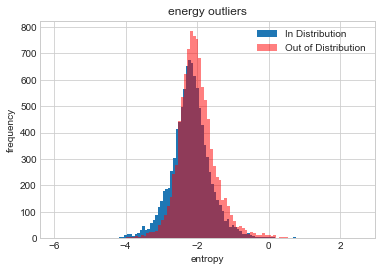

In [37]:
#crossEnergy
buildTPR(output_ID, output_OOD, ["energy"], "mean")

100
6408
TP_qual 9500
18.193120166508834 ID: 9663  OOD: 9363
22.363708650222918 ID: 9778  OOD: 9594
26.534297133937002 ID: 9868  OOD: 9744
30.704885617651144 ID: 9915  OOD: 9829
34.87547410136523 ID: 9945  OOD: 9885
39.04606258507931 ID: 9956  OOD: 9928
43.2166510687934 ID: 9966  OOD: 9955
47.38723955250748 ID: 9981  OOD: 9972
51.557828036221565 ID: 9986  OOD: 9981
55.728416519935706 ID: 9992  OOD: 9983
59.89900500364979 ID: 9995  OOD: 9988
64.06959348736387 ID: 9996  OOD: 9990
68.24018197107796 ID: 9998  OOD: 9994
72.41077045479204 ID: 9998  OOD: 9999
76.58135893850613 ID: 9998  OOD: 9999
80.75194742222027 ID: 9998  OOD: 10000
84.92253590593435 ID: 9999  OOD: 10000
89.09312438964844 ID: 10000  OOD: 10000


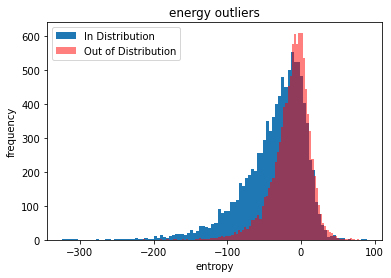

100
6408
TP_qual 9500
10.0 ID: 10000  OOD: 10000


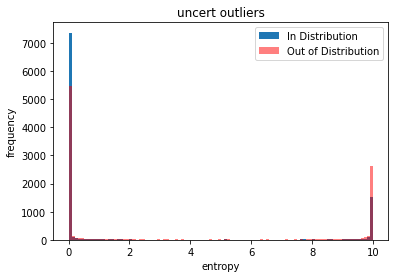

In [86]:
#EDL energy
buildTPR(output_ID, output_OOD, ["energy","uncert"], "mean")

In [88]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from matplotlib import pyplot
metrics = ['energy','entropy_of_expected']


def calc_aucpr(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = precision_recall_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, P={}, R={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        
        display = PrecisionRecallDisplay.from_predictions(y_test, output_df[metric], name="LinearSVC")
        _ = display.ax_.set_title("2-class Precision-Recall curve")
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy'],plot = True)
# print(threshold)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
precision_recall_fscore_support(output_ID['x'], output_ID['y'], average='macro')
# roc_auc_score(output_ID['correct'], output_ID['energy'])

(0.6464000000000001, 0.6490218675861255, 0.6450334719396431, None)

-37.470623
energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525


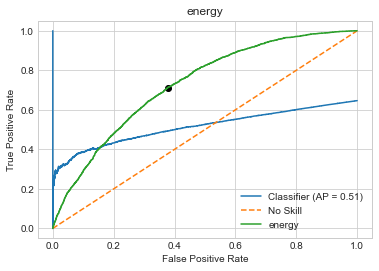

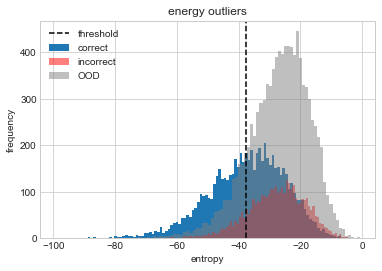

OOD accepted: 1447 : with threshold: -37.470623
ID accepted: 3537 :with acc: 0.8490245971162002
overall Accepted acc: 0.6025280898876404
TPR_ID-OOD 0.3537
TPR_acc 0.4645730198019802
FPR_ID-OOD 0.1447
FPR_acc 0.1510180995475113


In [104]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
y_test = output_ID['correct']
X_test = output_ID['energy']
precision_, recall_, proba = precision_recall_curve(y_test, X_test)

PrecisionRecallDisplay.from_predictions(output_ID['correct'], output_ID['energy'])

# PrecisionRecallDisplay(X_test, y_test)
# disp.ax_.set_title('Precision-Recall curve')

optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in X_test]
print(optimal_proba_cutoff)
# print(roc_predictions)
buildCompareDistribPlot(output_ID, output_OOD, ["energy"], optimal_proba_cutoff)

Best Threshold=-76.6483383178711, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=0.004616542719304562, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=3.495582809081781e-19, G-Mean=0.8007025231631392, P=1.0, R=0.35887546940018267
Best Threshold=0.3779428005218506, G-Mean=0.5945340142824697, P=1.0, R=0.6465293058611722


[]

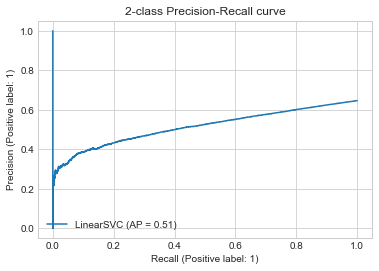

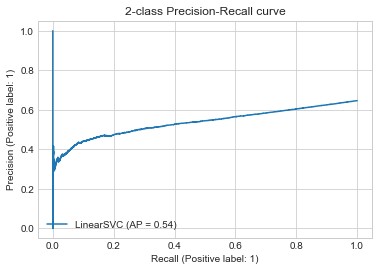

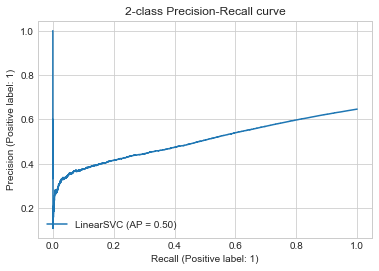

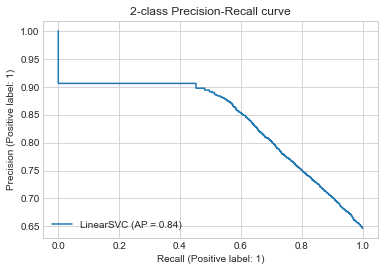

In [89]:
calc_aucpr(output_ID,metrics=["energy",'uncert','entropy','calibration'],plot=False)

max,min 1.0 0.36905995
0.3690599501132965 6464 3536
0.3754330819303339 6464 3535
0.38180621374737134 6463 3532
0.38817934556440875 6463 3531
0.39455247738144616 6463 3531
0.4009256091984835 6463 3528
0.407298741015521 6463 3526
0.41367187283255835 6463 3526
0.42004500464959577 6463 3524
0.4264181364666332 6463 3521
0.4327912682836706 6462 3517
0.439164400100708 6460 3517
0.4455375319177454 6460 3514
0.45191066373478284 6458 3513
0.45828379555182025 6458 3513
0.46465692736885766 6456 3509
0.471030059185895 6456 3506
0.4774031910029325 6456 3499
0.48377632281996985 6454 3495
0.49014945463700726 6452 3491
0.4965225864540447 6451 3488
0.502895718271082 6447 3481
0.5092688500881195 6438 3476
0.515641981905157 6435 3464
0.5220151137221943 6429 3452
0.5283882455392317 6425 3441
0.5347613773562692 6419 3430
0.5411345091733065 6415 3421
0.547507640990344 6411 3414
0.5538807728073813 6406 3406
0.5602539046244188 6401 3387
0.5666270364414562 6392 3379
0.5730001682584935 6385 3366
0.57937330007553

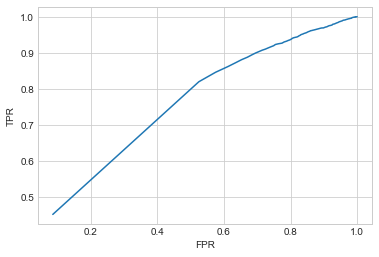

In [72]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot

def self_calc_AUC(output_df, metrics=['energy'], plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        #order the dataframe from lowest to highest
        df = output_df.sort_values(by=[metric,'correct'])
        t_max = df[metric].max()
        t_min = df[metric].min()
        print("max,min", t_max,t_min)
        #create a linspace
        linspace = np.linspace(t_min, t_max,num=100)
        Total_P = len(df.loc[df['correct']==True])
        Total_F = len(df.loc[df['correct']==False])
        TPR=[]
        FPR=[]
        for thresh in linspace:
            _outputs = df.loc[df[metric]>= thresh]
            correct = _outputs.loc[_outputs['correct']==True]
            incorrect = _outputs.loc[_outputs['correct']==False]
            print(thresh, len(correct), len(incorrect))
            _TPR = len(correct)/ Total_P
            _FPR = len(incorrect)/ Total_F
            TPR.append(_TPR)
            FPR.append(_FPR)
        # print(FPR)
        # print(TPR)
        pyplot.plot(FPR, TPR)
        pyplot.xlabel("FPR")
        pyplot.ylabel("TPR")
        pyplot.show()#     
# threshold = self_calc_AUC(output_ID, metrics=['energy'],plot = True)   
threshold = self_calc_AUC(output_ID, metrics=['calibration'],plot = True)   

energy  lr_auc 0.23328679452194093 Best Threshold=-48.40744400024414, G-Mean=0.7009286192837358, TPR=0.7452460850111857, FPR=0.3407534246575342


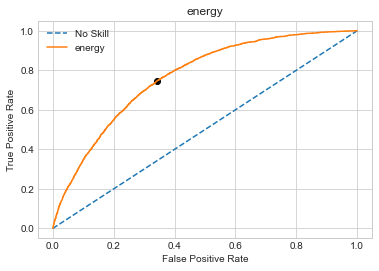

calibration  lr_auc 0.6673192808846022 Best Threshold=1.0, G-Mean=0.638403421479321, TPR=0.8429327521793275, FPR=0.5164988814317674


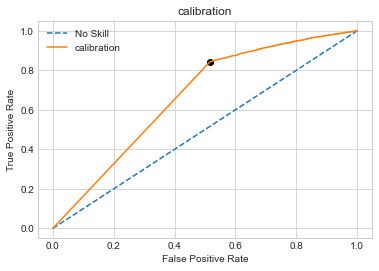

In [61]:
threshold = calc_AUC(output_ID, metrics=["energy"],plot = True)
threshold = calc_AUC(output_ID, metrics=["calibration"],plot = True)

In [41]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot
# metrics = ['energy','entropy_of_expected']


def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

#         accepted = output_df.loc[output_df[metric] <= threshold]
#         y_test_accept = np.int32(accepted['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted[metric])
#         print(len(thresholds))
#         print("lr_auc_accepted",lr_auc)

#         threshold2 = np.array(output_df.loc[output_df['correct']==True][metric]).mean()
#         accepted2 = output_df.loc[output_df[metric] <= threshold2]
#         y_test_accept = np.int32(accepted2['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted2[metric])
#         print("lr_auc_accepted2",lr_auc)



#         print(len(accepted), len(accepted.loc[(accepted['correct'] == True)]))
#         _ = pyplot.hist(output_df[metric].tolist(), bins=100,alpha=0.5)  # arguments are passed to np.histogram
#         _ = pyplot.hist(output_df.loc[(output_df['correct'] == True)][metric].tolist(), bins=100)  # arguments are passed to np.histogram
#         plt.axvline(x=threshold, color='k', linestyle='--',label="threshold")
#         pyplot.show()
            
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)


# print(threshold)

energy  lr_auc 0.23581525312294546 Best Threshold=-65.02085876464844, G-Mean=0.6930189181980165, TPR=0.7151234567901235, FPR=0.32840236686390534
entropy  lr_auc 0.21818394331214847 Best Threshold=7.617240171953199e-10, G-Mean=0.7112415642998093, TPR=0.7209876543209877, FPR=0.29837278106508874
uncert  lr_auc 0.2504219857184601 Best Threshold=0.01307495404034853, G-Mean=0.6874553625126794, TPR=0.6984567901234567, FPR=0.32337278106508877
confidence_alea_uncert  lr_auc 0.6952099998173716 Best Threshold=1.0, G-Mean=0.679469876950052, TPR=0.7714497041420119, FPR=0.4015432098765432
entropy_of_expected  lr_auc 0.7661175031046826 Best Threshold=-3.731665636471849e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
expected_entropy  lr_auc 0.7663178921031485 Best Threshold=-3.909963365774104e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
calibration  lr_auc 0.6932918310322156 Best Threshold=1.0, G-Mean=0.6743145587834388, TPR=0.797633136

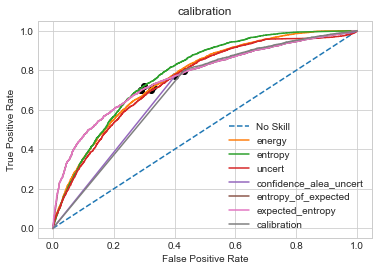

In [42]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)

energy  lr_auc 0.30746509020901197 Best Threshold=-12.230971336364746, G-Mean=0.6447222206555288, TPR=0.6918058455114823, FPR=0.39915693904020755
entropy  lr_auc 0.23931991909214234 Best Threshold=0.7835158109664917, G-Mean=0.6983915306471645, TPR=0.759133611691023, FPR=0.35749027237354086
uncert  lr_auc 0.35281864661435275 Best Threshold=0.3646439015865326, G-Mean=0.6121356188521229, TPR=0.6072546972860126, FPR=0.3829442282749676
confidence_alea_uncert  lr_auc 0.7616135598848119 Best Threshold=0.832136869430542, G-Mean=0.6976568205033336, TPR=0.6507782101167315, FPR=0.2520876826722338
entropy_of_expected  lr_auc 0.7578205598157641 Best Threshold=-0.5445331625295522, G-Mean=0.6981025938832756, TPR=0.6371595330739299, FPR=0.23512526096033404
expected_entropy  lr_auc 0.7583946471653817 Best Threshold=-0.540065626234581, G-Mean=0.6982834773852532, TPR=0.6355382619974059, FPR=0.23277661795407098
calibration  lr_auc 0.7630961428979526 Best Threshold=0.8225886821746826, G-Mean=0.697887108646

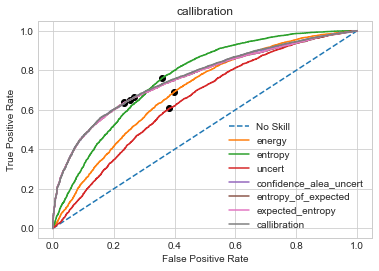

In [17]:
# threshold = calc_AUC(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#MAEB

lr_auc 0.29612755195940693
Best Threshold=-7.480616569519043, G-Mean=0.6498070813025146, TPR=0.7059282371294852, FPR=0.4018524536886578
lr_auc 0.24005162351440434
Best Threshold=0.9972052574157715, G-Mean=0.6950418578983907, TPR=0.7927717108684348, FPR=0.39064023399415015
lr_auc 0.37206364432672856
Best Threshold=0.44796812534332275, G-Mean=0.5952901008407016, TPR=0.6315652626105044, FPR=0.43890152746181343
lr_auc 0.7651199808148321
Best Threshold=0.7181436419487, G-Mean=0.7008415143051968, TPR=0.6670458238544036, FPR=0.26365054602184085
lr_auc 0.7568078446244773
Best Threshold=-0.8272647119808325, G-Mean=0.6919269077521468, TPR=0.6494962625934352, FPR=0.2628705148205928
lr_auc 0.7574571523647426
Best Threshold=-0.8330044417222909, G-Mean=0.6924701182740562, TPR=0.6542086447838804, FPR=0.2670306812272491
lr_auc 0.7660429881608655
Best Threshold=0.7298916578292847, G-Mean=0.7018544841976537, TPR=0.6711082222944427, FPR=0.265990639625585


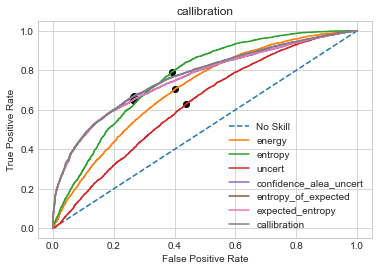

In [82]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#EDL

OOD size 10000
lr_auc 0.656151925
Best Threshold=-21.352628707885742, G-Mean=0.3962403815867333, TPR=0.3394, FPR=0.5374
lr_auc 0.65798663
Best Threshold=1.6821411918499507e-05, G-Mean=0.39619328616219635, TPR=0.3472, FPR=0.5479
lr_auc 0.644239215
Best Threshold=0.4506461024284363, G-Mean=0.4022347076024147, TPR=0.3214, FPR=0.4966
lr_auc 0.37535799999999997
Best Threshold=0.9999980926513672, G-Mean=0.3929694644625712, TPR=0.426, FPR=0.6375
lr_auc 0.34221492
Best Threshold=-3.639874760966167e-05, G-Mean=0.3932804088687866, TPR=0.4324, FPR=0.6423
lr_auc 0.34184017
Best Threshold=-3.848563147968418e-05, G-Mean=0.393089760741742, TPR=0.4338, FPR=0.6438
lr_auc 0.38505431
Best Threshold=0.9999992847442627, G-Mean=0.3960258829925135, TPR=0.4525, FPR=0.6534


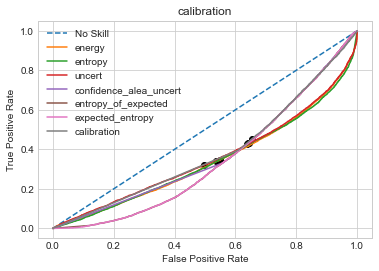

In [121]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    _output_ID = ID
    _output_OOD = OOD

    _output_ID["outlier"]=0
    _output_OOD["outlier"]=1
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    for i in OOD_rate:
        # print(int(min((len(_output_ID) * i),len(_output_ID))))
        _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
        print("OOD size",len(_OOD))
        _df = pd.concat([_output_ID,_OOD], ignore_index=True)
        y_true = np.int32(_df['outlier'])

    #     print(len(_df))
    #     for metric in metrics:
    #         points.append([])
    #         # print(metric, ":", average_precision_score(y_true, _df[metric]))

    #         Correct = _df.loc[(_df['correct'] == True)]
    #         Incorrect = _df.loc[(_df['correct'] == False)]
    #         fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
    #         gmeans = sqrt(tpr * (1-fpr))
    #         ix = argmax(gmeans)
    #         _threshold = thresholds[ix]
    #         # _threshold = np.array(Correct[metric]).mean()
        plots = []
        for metric in metrics:    
            lr_auc = roc_auc_score(y_true, _df[metric])
            print("lr_auc",lr_auc)
            if metric in lessThanMetrics:
                pos_label = 0
            else:
                pos_label = 1
            fpr, tpr, thresholds = roc_curve(y_true, _df[metric],pos_label=pos_label)
            gmeans = sqrt(tpr * (1-fpr))
            # print(gmeans)
            # locate the index of the largest g-mean
            ix = argmax(gmeans)
            threshold = thresholds[ix]
            print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
            _thresholds.append(threshold)
            # plot the roc curve for the model
            plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
        # if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

# def calc_gmeans(output_df,metrics=['energy'],plot=False):
#     lessThanMetrics = ["energy","uncert","entropy"]
#     _thresholds = []
    
#     y_test = np.int32(output_df['correct'])
#     plots = []
#     for metric in metrics:    
#         lr_auc = roc_auc_score(y_test, output_df[metric])
#         print("lr_auc",lr_auc)
#         if metric in lessThanMetrics:
#             pos_label = 0
#         else:
#             pos_label = 1
#         fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
#         gmeans = sqrt(tpr * (1-fpr))
#         # print(gmeans)
#         # locate the index of the largest g-mean
#         ix = argmax(gmeans)
#         threshold = thresholds[ix]
#         print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
#         _thresholds.append(threshold)
#         # plot the roc curve for the model
#         plots.append({"fpr":fpr,"tpr":tpr,"label":"metric", "ix":ix})
#     if plot:
#         pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         for plot in plots:
#             ix = plot['ix']
#             pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

#             pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
#         # axis labels
#         pyplot.xlabel('False Positive Rate')
#         pyplot.ylabel('True Positive Rate')
#         pyplot.title(metric)
#         pyplot.legend()
#         # show the plot
#         pyplot.show()
        

10000
lr_auc 0.17632298999999999
Best Threshold=-5.625901222229004, G-Mean=0.7577538320589345, TPR=0.7897, FPR=0.2729
lr_auc 0.163048365
Best Threshold=1.7985261678695679, G-Mean=0.7553904420893873, TPR=0.7592, FPR=0.2484
lr_auc 0.26289053
Best Threshold=0.45931094884872437, G-Mean=0.6940969240675253, TPR=0.7773, FPR=0.3802
lr_auc 0.83095955
Best Threshold=0.49477264285087585, G-Mean=0.7527356375248883, TPR=0.7481, FPR=0.2426
lr_auc 0.8377772299999999
Best Threshold=-1.3245874584253854, G-Mean=0.7618700217228658, TPR=0.7367, FPR=0.2121
lr_auc 0.83854707
Best Threshold=-1.3036969119965915, G-Mean=0.7614107432916875, TPR=0.7346, FPR=0.2108
lr_auc 0.8264950799999999
Best Threshold=0.5462754368782043, G-Mean=0.7462074711499478, TPR=0.7087, FPR=0.2143


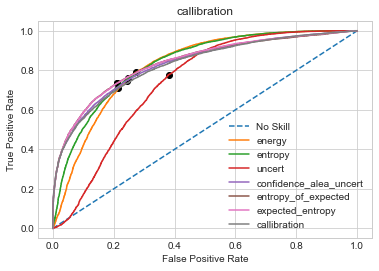

10000
lr_auc 0.3541886000000001
Best Threshold=-6.632209777832031, G-Mean=0.6040072847242821, TPR=0.6247, FPR=0.416
lr_auc 0.33489378000000003
Best Threshold=1.3389952182769775, G-Mean=0.6181435512888571, TPR=0.6535, FPR=0.4153
lr_auc 0.41053229999999996
Best Threshold=0.45440253615379333, G-Mean=0.5676407754909789, TPR=0.5759, FPR=0.4405
lr_auc 0.6552974600000001
Best Threshold=0.6583983302116394, G-Mean=0.6085316014801532, TPR=0.5677, FPR=0.3477
lr_auc 0.6647074949999999
Best Threshold=-1.0051595671170843, G-Mean=0.6170466676030266, TPR=0.5873, FPR=0.3517
lr_auc 0.6649351350000001
Best Threshold=-0.9957128697464878, G-Mean=0.6170181682900431, TPR=0.5858, FPR=0.3501
lr_auc 0.652951265
Best Threshold=0.7174296975135803, G-Mean=0.6068091627521787, TPR=0.5292, FPR=0.3042


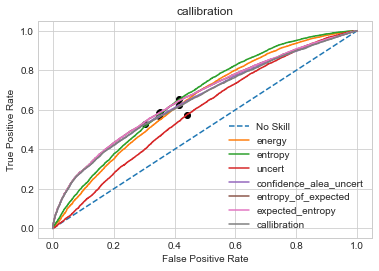

In [81]:
calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       


calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

In [46]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
metrics =["energy","entropy","calibration"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=0
_output_OOD["outlier"]=1
lessThanMetrics = ["energy","uncert","entropy"]
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # print(metric, ":", average_precision_score(y_true, _df[metric]))
        
        Correct = _df.loc[(_df['correct'] == True)]
        Incorrect = _df.loc[(_df['correct'] == False)]
        fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        _threshold = thresholds[ix]
        # _threshold = np.array(Correct[metric]).mean()
        if metric in lessThanMetrics:
            accepted = _df.loc[(_df[metric] <= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)]
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
            # print(metric, ":", len(Correct)/len(_df), "accepted_acc", len(accepted_correct)/len(accepted))
        else:
            accepted = _df.loc[(_df[metric] >= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)] #TP
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
        try:
            ODD_accept = len(accepted_OOD)/len(_OOD)
        except:
            ODD_accept ="NAN"
        np.seterr(invalid='ignore')
        AUC_PR_OOD = average_precision_score(np.int32(accepted['outlier']), accepted[metric])
        AUC_ROC = roc_auc_score(np.int32(accepted['correct']), accepted[metric])
        AUC_PR = average_precision_score(np.int32(accepted['correct']), accepted[metric])
        FPR = len(accepted_incorrect) / (len(accepted_incorrect) + len(rejected_incorrect))
        print(metric,":",len(accepted_ID)/len(_output_ID),":",ODD_accept, ":", len(accepted_correct)/len(accepted), ":FPR:",FPR,":AUC_PR(T/F):",AUC_PR,":AUC_ROC:",AUC_ROC)


0
10000
energy : 0.5996 : NAN : 0.7198132088058706 :FPR: 0.4384133611691023 :AUC_PR(T/F): 0.6245638987195575 :AUC_ROC: 0.3303461097135796
entropy : 0.5763 : NAN : 0.7666146104459483 :FPR: 0.3509916492693111 :AUC_PR(T/F): 0.6477462359394405 :AUC_ROC: 0.25846595795167115
calibration : 0.5131 : NAN : 0.7998440849736893 :FPR: 0.2680062630480167 :AUC_PR(T/F): 0.9133633355608572 :AUC_ROC: 0.7249858119278505
1000
11000
energy : 0.5996 : 0.412 : 0.6735330836454432 :FPR: 0.4329470198675497 :AUC_PR(T/F): 0.5706115701137225 :AUC_ROC: 0.32503273869119664
entropy : 0.5763 : 0.344 : 0.7234321270672999 :FPR: 0.34954470198675497 :AUC_PR(T/F): 0.5999034689406928 :AUC_ROC: 0.26439191519916505
calibration : 0.5131 : 0.288 : 0.7573353017161838 :FPR: 0.2721440397350993 :AUC_PR(T/F): 0.8915049540682882 :AUC_ROC: 0.7213421571461396
2000
12000
energy : 0.5996 : 0.409 : 0.6334018197828001 :FPR: 0.4283264746227709 :AUC_PR(T/F): 0.5270595868474839 :AUC_ROC: 0.3237112396126354
entropy : 0.5763 : 0.342 : 0.6852799

0
10000
Best Threshold=-1.9426160284718987, G-Mean=0.82936722867497, Recall=1.0, Precision=0.37573757375737576


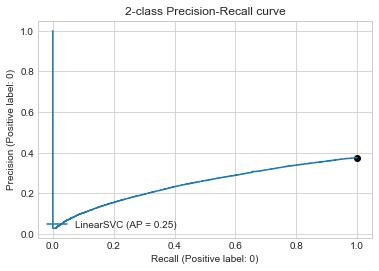

1000
11000
Best Threshold=-1.9430203248942899, G-Mean=0.82936722867497, Recall=1.0, Precision=0.4324545454545455


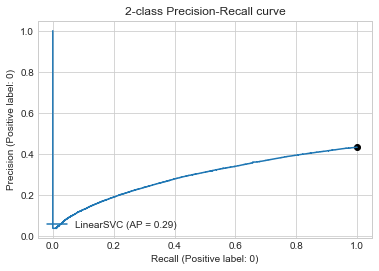

2000
12000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.47975


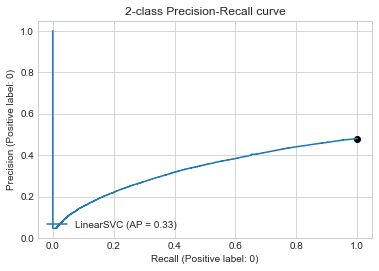

5000
15000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.5838


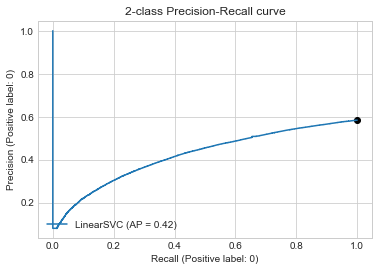

10000
20000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.68785


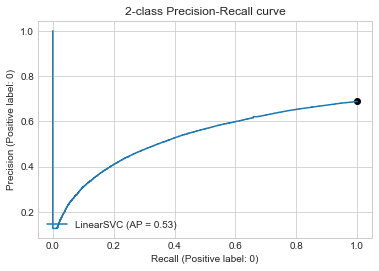

In [256]:
from sklearn.metrics import average_precision_score

metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"]
metrics =["expected_entropy"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=1
_output_OOD["outlier"]=0
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # calc_aucpr(_df,plot=True)
        precision, recall, thresholds = precision_recall_curve(np.int32(_df['correct']), _df[metric],pos_label =0)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, Recall={}, Precision={}'.format(threshold, gmeans[ix],recall[ix],precision[ix]))
        
        display = PrecisionRecallDisplay.from_predictions( np.int32(_df['correct']), _df[metric], name="LinearSVC",pos_label =0 )
        _ = display.ax_.set_title("2-class Precision-Recall curve") 
        pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        plt.show()
        # Correct = _df.loc[(_df['correct'] == True)]
        # Incorrect = _df.loc[(_df['correct'] == False)]
        # print(metric, ":", len(Correct)/len(_df))

        


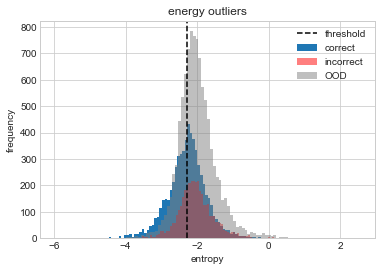

OOD accepted: 2780 : with threshold: -2.2853544
ID accepted: 4042 :with acc: 0.735526966848095
overall Accepted acc: 0.43579595426561124
TPR_ID-OOD 0.4042
TPR_acc 0.47820492198809716
FPR_ID-OOD 0.278
FPR_acc 0.2825799629923341


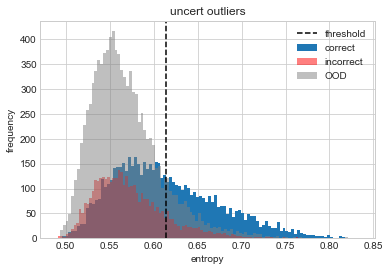

OOD accepted: 8740 : with threshold: 0.61375415
ID accepted: 6719 :with acc: 0.5194225331150469
overall Accepted acc: 0.22575845785626497
TPR_ID-OOD 0.6719
TPR_acc 0.5613640019301914
FPR_ID-OOD 0.874
FPR_acc 0.8535553793285752


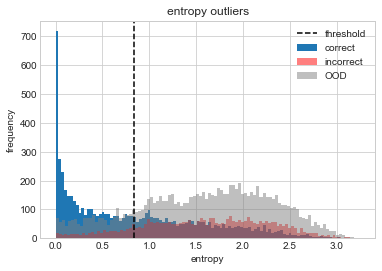

OOD accepted: 1767 : with threshold: 0.83682126
ID accepted: 4076 :with acc: 0.8626104023552502
overall Accepted acc: 0.6017456785897656
TPR_ID-OOD 0.4076
TPR_acc 0.5655460833199292
FPR_ID-OOD 0.1767
FPR_acc 0.14803066349458102


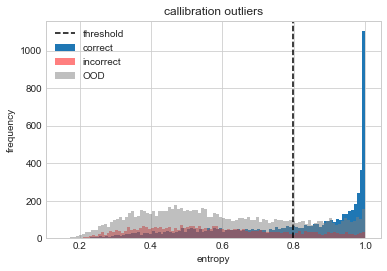

OOD accepted: 2215 : with threshold: 0.79617167
ID accepted: 4416 :with acc: 0.845108695652174
overall Accepted acc: 0.5628110390589655
TPR_ID-OOD 0.4416
TPR_acc 0.6002895287115972
FPR_ID-OOD 0.2215
FPR_acc 0.18080888183980967


In [35]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

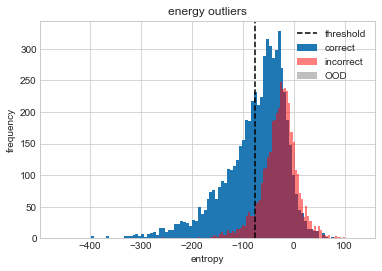

OOD accepted: 0 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8790149892933619
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.08580106302201974


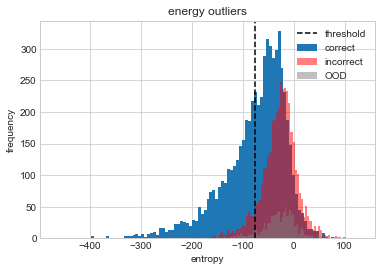

OOD accepted: 94 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8504834254143646
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.094
FPR_acc 0.08580106302201974


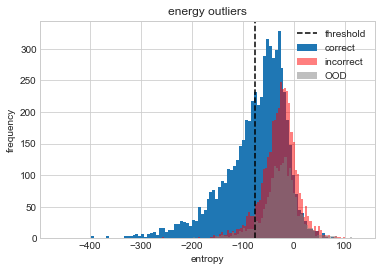

OOD accepted: 173 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8278991596638655
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.0865
FPR_acc 0.08580106302201974


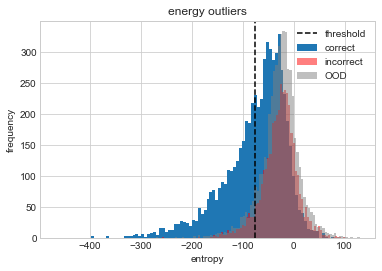

OOD accepted: 455 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.7562173779551735
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.091
FPR_acc 0.08580106302201974


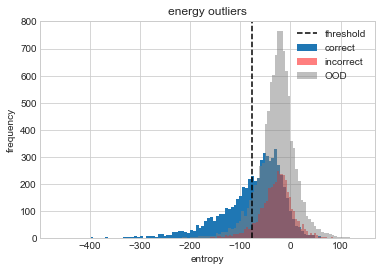

OOD accepted: 904 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.6645979492714517
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.0904
FPR_acc 0.08580106302201974


In [97]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")

# buildCompareDistribPlot(output_ID, output_OOD, ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"], threshold = "gmean")
# buildCompareDistribPlot(output_ID, output_OOD, ["energy","energy"], threshold = [-25.654110,"mean",-1.9786984131020736e-08])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:0], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:1000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:2000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:5000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:10000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])



In [315]:
def buildCompareDistribPlot2(ID,OOD=None,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        OOD_rate = [0,.1,.2,.5,1]
        throughput_acc= []
        for val in OOD_rate:
            print(int(min((len(_output_ID) * val),len(_output_ID))))
            OOD = OOD.iloc[0:int(min((len(ID) * val),len(ID)))]
            # _df = pd.concat([_output_ID,_OOD], ignore_index=True)
            # y_true = np.int32(_df['outlier'])
            for i, metric in enumerate(metrics):
                throughput_acc.append([])
                # _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                # _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                # _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                # if OOD is None:
                #     OOD = pd.DataFrame(columns=ID.columns)
                # _ = plt.hist(OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")


                if threshold:
                    if type(threshold) is list:
                        if i >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[i]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        # _threshold = np.array(ID[metric]).mean()
                        fpr, tpr, thresholds = roc_curve(np.int32(ID['correct']), ID[metric],pos_label=0)
                        gmeans = sqrt(tpr * (1-fpr))
                        ix = argmax(gmeans)
                        _threshold = thresholds[ix]
                    else:
                        _threshold = np.float32(_threshold)
                    # plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    # plt.title(metric + " outliers")
                    # plt.legend(legend)
                    # plt.xlabel("entropy")
                    # plt.ylabel("frequency")
                    # plt.show()
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = OOD.loc[(OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = OOD.loc[(OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = ID.loc[(ID[metric] <= _threshold)] #TP
                        ID_rejected = ID.loc[(ID[metric] > _threshold)] #FN


                        accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
                        rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN

                        accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
                        rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = OOD.loc[(OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = OOD.loc[(OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = ID.loc[(ID[metric] >= _threshold)] #TP
                        ID_rejected = ID.loc[(ID[metric] < _threshold)] #FN

                        accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
                        rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN

                        accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
                        rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))

                    print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                    print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                    if len(OOD) > 0:
                        print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                    else: 
                        print("FPR for OOD is div by zero, was OOD included?")
                    print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))
                    throughput_acc[i].append(overall_accepted_acc)
        print(throughput_acc)
        # for throughput in throughput_acc:
            # plt.plot(OOD_rate,throughput)

** CE RESULTS ** <hr>

In [316]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")

buildCompareDistribPlot2(output_ID, output_OOD, ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"], "mean")

0
OOD accepted: 0 : with threshold: -54.0084
ID accepted: 2805 :with acc: 0.9258467023172906
overall Accepted acc: 0.9258467023172906
TPR_ID-OOD 0.2805
TPR_acc 0.41598590421271825
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.05536332179930796
OOD accepted: 0 : with threshold: 0.018136319
ID accepted: 9084 :with acc: 0.658300308234258
overall Accepted acc: 0.658300308234258
TPR_ID-OOD 0.9084
TPR_acc 0.9578728175556623
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.8261911099281342
OOD accepted: 0 : with threshold: 0.3000143
ID accepted: 4458 :with acc: 0.8582323912068192
overall Accepted acc: 0.8582323912068192
TPR_ID-OOD 0.4458
TPR_acc 0.6128463879545091
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.16821932392866648
OOD accepted: 0 : with threshold: 0.8975615
ID accepted: 7468 :with acc: 0.723888591322978
overall Accepted acc: 0.723888591322978
TPR_ID-OOD 0.7468
TPR_acc 0.865929841422393
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.548842161298

** EDL Results ** <hr>

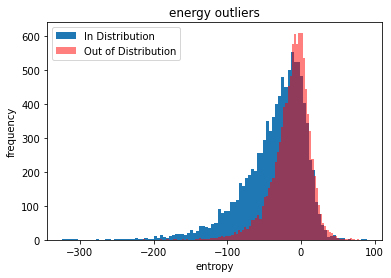

OOD accepted with avg ID  energy  threshold of  -35.58012602272332 :  1560 out of  10000
ID accepted with avg ID  energy  threshold of  -35.58012602272332 :  4085 out of  10000 with acc of  0.8832313341493268
Overall accuracy of accepted inputs: 0.6391496899911426
overall acc on ID: 0.6408


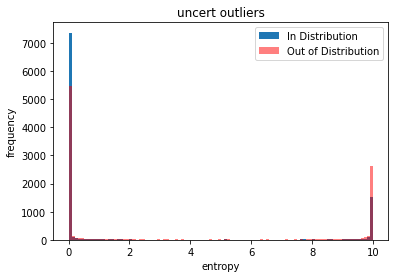

OOD accepted with avg ID  uncert  threshold of  2.0591965 :  6119 out of  10000
ID accepted with avg ID  uncert  threshold of  2.0591965 :  7778 out of  10000 with acc of  0.7247364361018257
Overall accuracy of accepted inputs: 0.40562711376556093
overall acc on ID: 0.6408


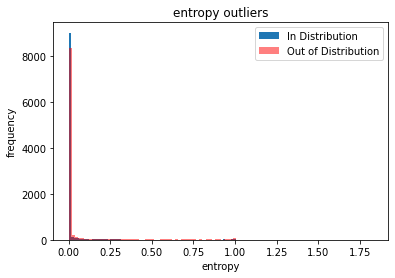

OOD accepted with avg ID  entropy  threshold of  0.03707295 :  8571 out of  10000
ID accepted with avg ID  entropy  threshold of  0.03707295 :  9176 out of  10000 with acc of  0.6705536181342633
Overall accuracy of accepted inputs: 0.34670648560320055
overall acc on ID: 0.6408


In [43]:


energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")
# buildCompareDistribPlot(output_ID, output_OOD, "uncert", edl_threshold)
# buildOutlierPlot_multi(output_ID, output_OOD, "entropy", entropy_threshold)

In [38]:
# print(remade_ood_scores(test_ds,stopping_point=10).mean())
# output = getPredictions_Energy(model, test_ds,stopping_point=None)
output = output_ID
Correct = output.loc[output['correct']==True]
Incorrect = output.loc[output['correct']==False]
print(len(Correct))
print(len(Incorrect))


6330
3654


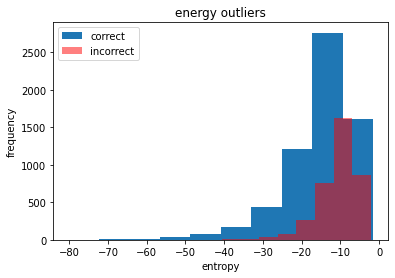

OOD accepted with avg ID  energy  threshold of  -15.44441713751963 :  523 out of  3654
ID accepted with avg ID  energy  threshold of  -15.44441713751963 :  2463 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.8248492967180174
overall acc on ID: 1.0


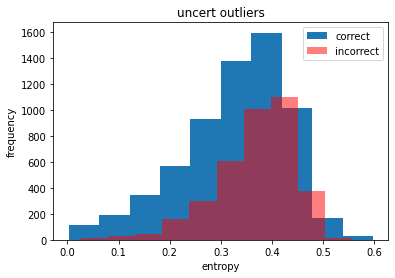

OOD accepted with avg ID  uncert  threshold of  0.32769838 :  929 out of  3654
ID accepted with avg ID  uncert  threshold of  0.32769838 :  2762 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.7483066919534002
overall acc on ID: 1.0


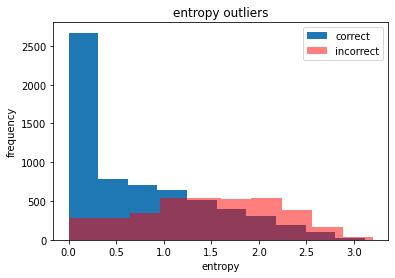

OOD accepted with avg ID  entropy  threshold of  0.72378 :  638 out of  3654
ID accepted with avg ID  entropy  threshold of  0.72378 :  3695 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.8527579044541888
overall acc on ID: 1.0


In [39]:
### CE

### ID, correct vs incorrect distributions.
buildCompareDistribPlot(Correct, Incorrect, ["energy",'uncert','entropy'], "mean",legend=["correct","incorrect"])

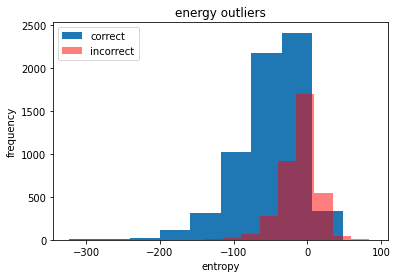

OOD accepted with avg ID  energy  threshold of  -49.36437512047334 :  219 out of  3585
ID accepted with avg ID  energy  threshold of  -49.36437512047334 :  2729 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.9257123473541384
overall acc on ID: 1.0


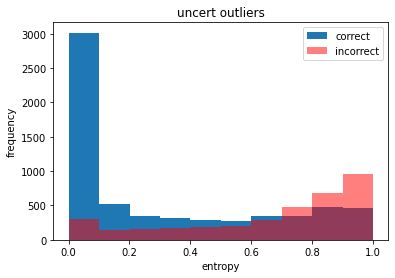

OOD accepted with avg ID  uncert  threshold of  0.30378383 :  616 out of  3585
ID accepted with avg ID  uncert  threshold of  0.30378383 :  3891 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.8633237186598625
overall acc on ID: 1.0


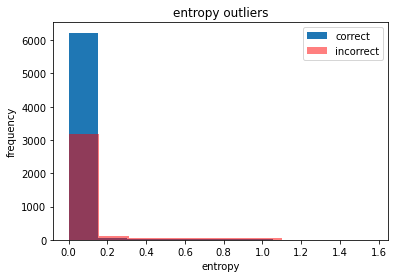

OOD accepted with avg ID  entropy  threshold of  0.01742948 :  2923 out of  3585
ID accepted with avg ID  entropy  threshold of  0.01742948 :  6097 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.6759423503325942
overall acc on ID: 1.0


In [19]:
### EDL

### ID, correct vs incorrect distributions.
buildCompareDistribPlot(Correct, Incorrect, ["energy",'uncert','entropy'], "mean",legend=["correct","incorrect"])

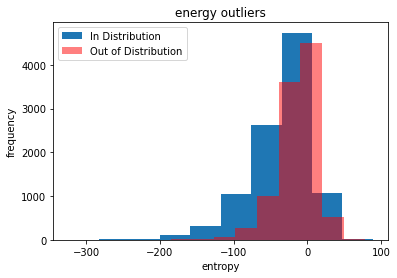

OOD accepted with avg ID  energy  threshold of  -35.59758201863709 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758201863709 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


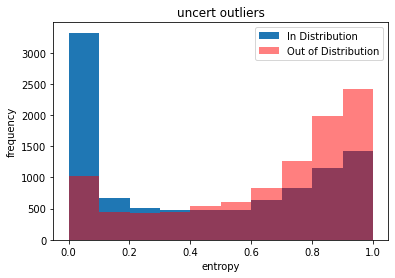

OOD accepted with avg ID  uncert  threshold of  0.43300316 :  2524 out of  9984
ID accepted with avg ID  uncert  threshold of  0.43300316 :  5139 out of  9984 with acc of  0.8355711227865343
Overall accuracy of accepted inputs: 0.5603549523685241
overall acc on ID: 0.6409254807692307


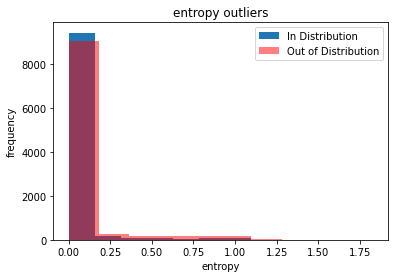

OOD accepted with avg ID  entropy  threshold of  0.036932714 :  8556 out of  9984
ID accepted with avg ID  entropy  threshold of  0.036932714 :  9161 out of  9984 with acc of  0.67066914092348
Overall accuracy of accepted inputs: 0.34678557317830333
overall acc on ID: 0.6409254807692307


In [16]:
def buildCompareDistribPlot_increasing(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
                metrics = [metrics]
        for i, metric in enumerate(metrics):
            _ = plt.hist(ID[metric].tolist(), bins=10)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                print("overall acc on ID:",len(Correct)/len(ID))

energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")
# buildCompareDistribPlot(output_ID, output_OOD, "uncert", edl_threshold)
# buildOutlierPlot_multi(output_ID, output_OOD, "entropy", entropy_threshold)

-13.265087624612557


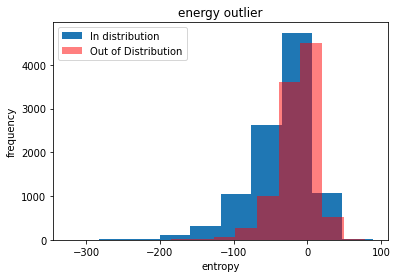

OOD accepted with avg ID entropy threshold of  -13.265087624612557 :  4201 out of  9984
ID accepted with avg ID entropy threshold of  -13.265087624612557 :  6518 out of  9984 with acc of  0.7821417612764652
overall acc on ID: 0.6409254807692307


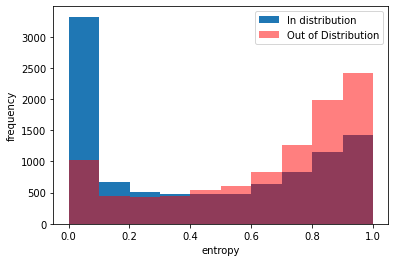

OOD accepted with avg ID entropy threshold of  0.6440355 :  3811 out of  9984
ID accepted with avg ID entropy threshold of  0.6440355 :  6209 out of  9984 with acc of  0.7935255274601385
overall acc on ID: 0.6409254807692307


In [286]:

energy_threshold = np.array(output_OOD['energy']).mean()
print(energy_threshold)
buildOutlierPlot_energy_2(output_ID, output_OOD, energy_threshold)

edl_threshold = output_OOD['uncert'].mean()
buildOutlierPlot(output_ID, output_OOD, edl_threshold)

In [19]:
def buildOutlierPlot_multi(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]

                percents.append(percent/2)
                accuracy.append(len(Correct) / total_inputs)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("outliers")
        plt.legend(metrics)
        plt.xlabel("Outlier percentage")
        plt.ylabel("Accuracy")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

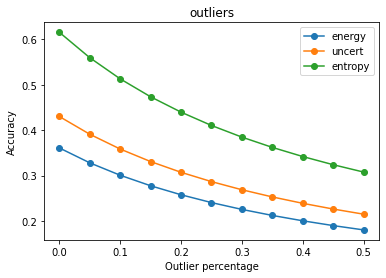

In [20]:
multiplot = buildOutlierPlot_multi(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [36]:
def buildOutlierPlot_AUC(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                #x =  false positive / sum(false positive + True Negative)
                # that thresholded are negative, so ID thresh is FN, OOD thresh is TN
                TP =  ID.loc[ID[metric]<=_threshold] #ID that are accepted 
                TN = _OOD.loc[_OOD[metric]>_threshold] #OOD that are not accepted 
                FN =  _OOD.loc[_OOD[metric]<=_threshold] #ID that are accepted 
                FP =  ID.loc[ID[metric]>_threshold] #ID that are accepted 
                
                _TP = len(TP)
                _TN = len(TN)
                _FN = len(FN)
                _FP = len(FP)
                
                # print("TP", len(TP), "TN",len(TN),"FN",len(FN),"FP",len(FP))
                x = _FP/ (_FP + _TN)
                
                y = _TP/(_TP+_FN)
                
                print(x,y)
                percents.append(x)
                accuracy.append(y)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("AUC OOD")
        plt.legend(legend)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

1.0 1.0
0.8737792246226694 0.9656723484848485
0.7777924130663857 0.9295806745670009
0.699893327011971 0.8980625275209159
0.6356297093649085 0.8702794964796245
0.5818307222386442 0.8450383260824529
0.5384825825278132 0.8144968051118211
0.4997461069735951 0.7911171450737006
0.4664296998420221 0.7680286198456034
0.43747221810638615 0.7455675379272528
0.4119575833682154 0.7239971600993965
1.0 1.0
0.8673469387755102 0.9523721275018532
0.7658868163136263 0.9089140431552883
0.6846121237812632 0.8707217892239919
0.618379068283344 0.8366981439270595
0.5639622861133745 0.8048551292090838
0.5199055692670888 0.7722013523666417
0.4803212055120452 0.74640522875817
0.4472858197932053 0.7198487183078862
0.41832153341391815 0.6956816028157574
0.3937423811458757 0.6706250815607464
1.0 1.0
0.849329205366357 0.9149106161989414
0.7421100090171325 0.8427007634992181
0.6495659037095501 0.7821892076502732
0.5857651245551602 0.7286827871460388
0.5323415265200517 0.6821295606850335
0.4852594339622642 0.64161647

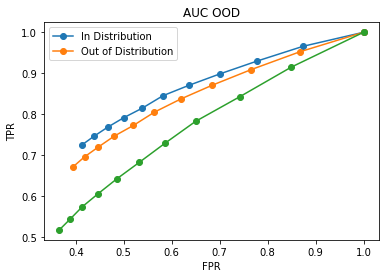

In [37]:
multiplot = buildOutlierPlot_AUC(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [136]:
output_OOD_edl_100

,x,y,uncert,correct
0,0,49,0.074795,0
1,4,33,0.920631,0
2,4,72,0.631980,0
3,4,51,0.956106,0
4,9,71,0.496918,0
...,...,...,...,...
347,4,7,0.874040,0
348,6,10,0.877300,0
349,6,10,0.816564,0
350,0,68,0.317638,0


In [26]:
### find the optimal threshold between OOD and ID distributions

#combine the sets to find the min and max values for the energy
combined = pd.concat([output_ID,output_OOD])
print(combined)
max_energy = combined['energy'].max()
min_energy = combined['energy'].min()



      x   y    uncert     energy       entropy  calibration correct
0     3   3  0.611689 -18.383732  4.069851e-22      1.000000       1
1     8   8  0.000506 -98.917679 -0.000000e+00      1.000000       1
2     8   8  0.355745 -28.929207  1.759550e-24      1.000000       1
3     0   0  0.020281 -61.801628 -0.000000e+00      1.000000       1
4     6   6  0.859234   0.538187  2.543902e-01      0.957333       1
...  ..  ..       ...        ...           ...           ...     ...
9979  1  27  0.300283 -31.417620  1.202746e-20      1.000000       0
9980  2  30  0.612614 -18.393915  3.585178e-25      1.000000       0
9981  3  52  0.751146  -9.438948  1.814422e-06      1.000000       0
9982  1  74  0.903684   1.034829  3.290858e-10      1.000000       0
9983  6  29  0.224972 -35.289570  1.147606e-18      1.000000       0

[19968 rows x 7 columns]
89.0931396484375 -323.79510498046875


In [140]:

def comparePredictions_Energy(model, input_set, stopping_point=None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]
    T = 1 ### temperature variable
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
            # Energy.append(prediction.mean() -(logsumexp(prediction)))
            Energy.append( -(1 * logsumexp(np.array(prediction)/1)))
            Energy_softmax.append( -(1 * logsumexp(np.array(tf.nn.softmax(prediction))/1)))
            Energy_evidence.append( -(1 * logsumexp(np.array(evidence)/1)))
            Energy_alpha.append( -(1 * logsumexp(np.array(alpha)/1)))
            Energy_Mass.append( -(1 * logsumexp(np.array(Mass)/1)))
            
            
            Entropy.append(calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
            calibration.append(np.amax(tf.nn.softmax(prediction).numpy()))
    _uncert = np.array(Uncert)
    # print(_uncert)
    print("")
    print("avg entropy",_uncert.mean())
    print("avg energy",np.array(Energy).mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df
# buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

In [141]:
output_ID_energy =  comparePredictions_Energy(model, test_ds,stopping_point=None)
output_OOD_energy = comparePredictions_Energy(model, test_ds100,stopping_point=None)


prediction: 312 of 313
avg entropy 0.20990698
avg energy -59.24956272488758
prediction: 312 of 313
avg entropy 0.37043014
avg energy -33.23839231808018


In [143]:
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(OOD[metric]).mean()
                print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                Correct = ID.loc[(ID['correct'] == True)]
                # print(len(Correct))
                Incorrect = ID.loc[(ID['correct'] == False)]
                print("overall acc on ID:",len(Correct)/len(ID))

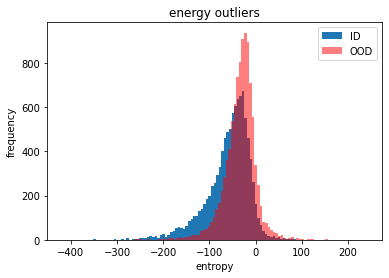

OOD accepted with avg ID  energy  threshold of  -33.23839231808018 :  4458 out of  10000
ID accepted with avg ID  energy  threshold of  -33.23839231808018 :  6787 out of  10000 with acc of  0.7697067923972299
Overall accuracy of accepted inputs: 0.4645620275678079
overall acc on ID: 0.6579


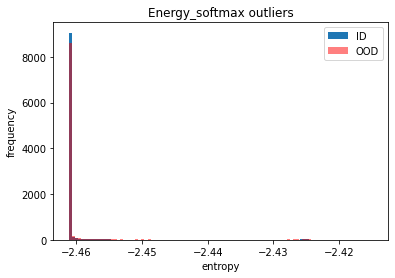

In [ ]:
#EDL _ energy loss
buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

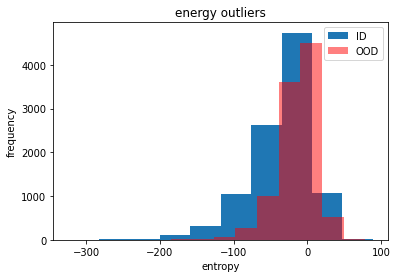

OOD accepted with avg ID  energy  threshold of  -35.59758201863709 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758201863709 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


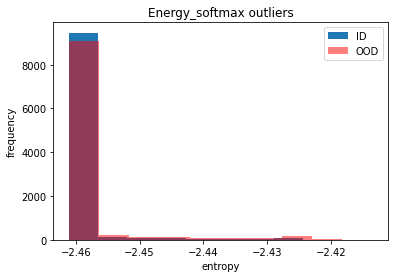

OOD accepted with avg ID  Energy_softmax  threshold of  -2.460042773745954 :  8719 out of  9984
ID accepted with avg ID  Energy_softmax  threshold of  -2.460042773745954 :  9277 out of  9984 with acc of  0.6665948043548561
Overall accuracy of accepted inputs: 0.3436319182040453
overall acc on ID: 0.6409254807692307


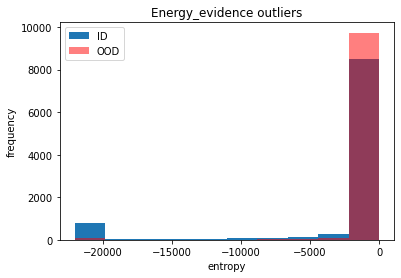

OOD accepted with avg ID  Energy_evidence  threshold of  -2384.261512561295 :  239 out of  9984
ID accepted with avg ID  Energy_evidence  threshold of  -2384.261512561295 :  1457 out of  9984 with acc of  0.9718599862731641
Overall accuracy of accepted inputs: 0.8349056603773585
overall acc on ID: 0.6409254807692307


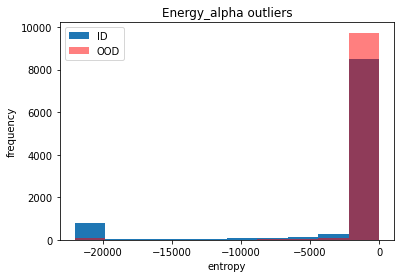

OOD accepted with avg ID  Energy_alpha  threshold of  -2385.2615125646385 :  239 out of  9984
ID accepted with avg ID  Energy_alpha  threshold of  -2385.2615125646385 :  1457 out of  9984 with acc of  0.9718599862731641
Overall accuracy of accepted inputs: 0.8349056603773585
overall acc on ID: 0.6409254807692307


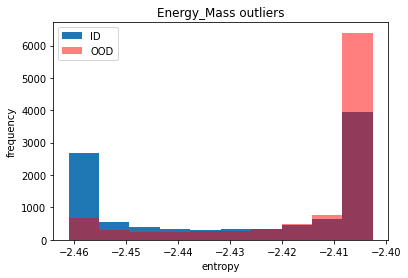

OOD accepted with avg ID  Energy_Mass  threshold of  -2.427978648517567 :  1902 out of  9984
ID accepted with avg ID  Energy_Mass  threshold of  -2.427978648517567 :  4473 out of  9984 with acc of  0.8667560921082048
Overall accuracy of accepted inputs: 0.6081568627450981
overall acc on ID: 0.6409254807692307


In [25]:
buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

89.0931396484375 -323.79510498046875
1


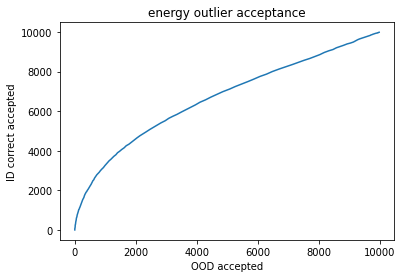

0.9999455 0.00041522982
0.009995303153991698


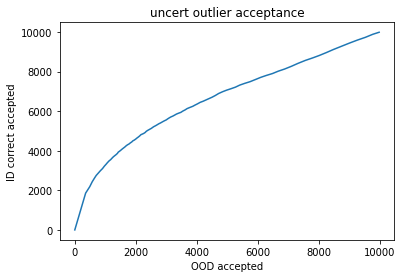

1.8287096 -0.0
0.01828709602355957


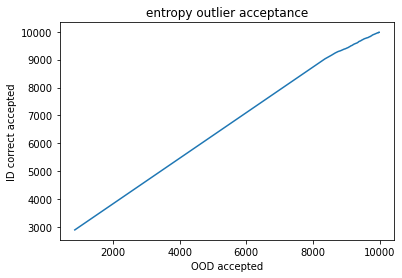

In [121]:
energy_range = range(int(min_energy-1), int(max_energy+1))
metric = "energy"
combined = pd.concat([output_ID,output_OOD])

for metric in ["energy","uncert","entropy"]:

    OOD_accepted= []
    ID_accepted = []
    points =[]
    max_energy = combined[metric].max()
    min_energy = combined[metric].min()
    print(max_energy, min_energy)
    step = min((max_energy - min_energy) /100,1)
    print(step)
    # energy_range = range((min_energy), (max_energy))
    energy_range = np.arange (min_energy, max_energy, step)
    # print(energy_range)
    
    for _threshold in energy_range:

        
        # print(len(output_OOD.loc[output_OOD[metric] <= _threshold]))
        # print(_threshold)
        OOD_accepted.append( len(output_OOD.loc[output_OOD[metric] <= _threshold]))
        # OOD_accepted.append(_threshold)
        # if len(output_ID.loc[(output_ID[metric] <= _threshold)]) > 0:
        # ID_accepted.append( len(output_ID.loc[(output_ID[metric] <= _threshold) & output_ID['correct'] == True]))#/ len(output_ID.loc[(output_ID[metric] <= _threshold)]))
        ID_accepted.append( len(output_ID.loc[(output_ID[metric] <= _threshold) ]))#/ len(output_ID.loc[(output_ID[metric] <= _threshold)]))
        # print(_threshold, len(output_OOD.loc[output_OOD[metric] <= _threshold]),len(output_ID.loc[(output_ID[metric] <= _threshold) ]))
        # if _threshold == 0:
            # points.append([ len(output_OOD.loc[output_OOD[metric] <= _threshold]),len(output_ID.loc[(output_ID[metric] <= _threshold) & output_ID['correct'] == True])])

        # else: 
            # ID_accepted.append(0)
    plt.title(metric + " outlier acceptance")
    plt.plot(OOD_accepted,ID_accepted)
    plt.xlabel("OOD accepted")
    plt.ylabel("ID correct accepted")
    plt.show()


In [50]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [77]:
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(-200, 100, num=500)
good_pdf = pdf(x,output_ID['energy'].std(),output_ID["energy"].mean())
bad_pdf = pdf(x,output_OOD['energy'].std(),output_OOD["energy"].mean())

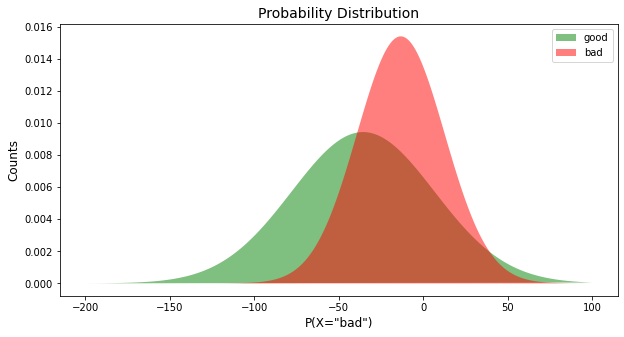

In [85]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

x = np.linspace(-200, 100, num=500)
good_pdf = pdf(x,output_ID['energy'].std(),output_ID["energy"].mean())
bad_pdf = pdf(x,output_OOD['energy'].std(),output_OOD["energy"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)
    

    

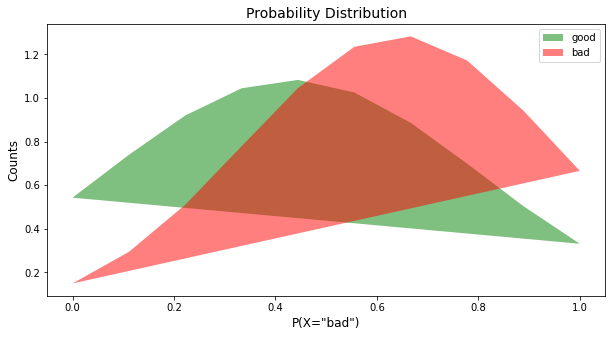

In [90]:
x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,output_ID['uncert'].std(),output_ID["uncert"].mean())
bad_pdf = pdf(x,output_OOD['uncert'].std(),output_OOD["uncert"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

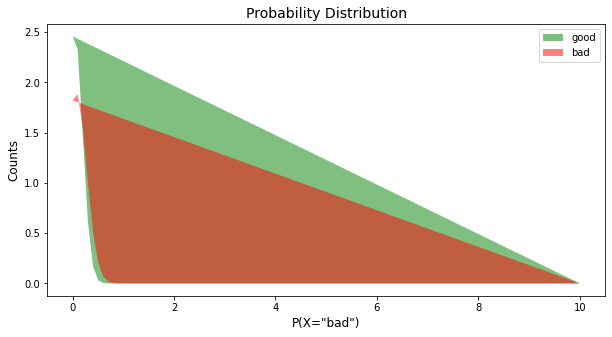

In [97]:
x = np.linspace(0, 10, num=100)
good_pdf = pdf(x,output_ID['entropy'].std(),output_ID["entropy"].mean())
bad_pdf = pdf(x,output_OOD['entropy'].std(),output_OOD["entropy"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

In [82]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/500
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])

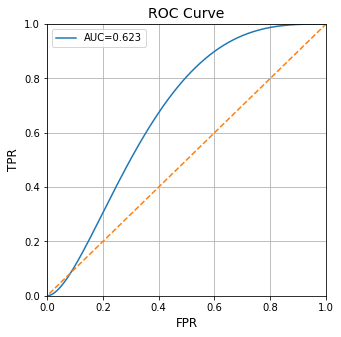

In [83]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_roc(good_pdf, bad_pdf, ax)

In [40]:
x = np.array([1.,2.,3.,4.,5.,6.])
tf.nn.softmax(x)

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.23312201,
       0.63369132])>

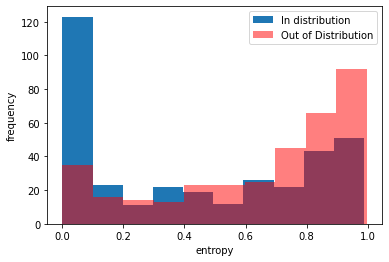

In [137]:
def buildOutlierPlot(ID,OOD,threshold=None):
    _ = plt.hist(ID['uncert'], bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'], bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    if threshold:
        print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        Correct = ID.loc[(ID['correct'] == True)]
        Incorrect = ID.loc[(ID['correct'] == False)]
        print("overall acc on ID:",len(Correct)/len(ID))

# buildOutlierPlot(outputs_test, outputs100, 0.4392441)

buildOutlierPlot(output_ID_edl, output_OOD_edl_100, None)

In [100]:
# num_right = len(right_score)
# num_wrong = len(wrong_score)
# print(num_right)
# print(num_wrong)
# print('Error Rate {:.2f}'.format(100 * num_wrong / (num_wrong + num_right)))

64
64
Error Rate 50.00


In [ ]:

outputs_test = evaluate.getPredictions_energy(model,test_ds)
print(outputs_test)
        
outputs100 = evaluate.getPredictions_energy(model,test_ds100)
print(outputs100)


[]ediction: 311 of 312
avg entropy nan


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      x  y  confidence_alea_uncert.  entropy_of_expected  expected_entropy  \
0     8  3                 0.814705            -0.482196         -0.482049   
1     8  8                 0.999999            -0.000019         -0.000019   
2     0  8                 0.525802            -0.693304         -0.693240   
3     0  0                 0.999313            -0.005692         -0.005692   
4     6  6                 0.990790            -0.055615         -0.055382   
...  .. ..                      ...                  ...               ...   
9979  5  3                 0.718007            -0.610635         -0.609681   
9980  0  0                 0.964415            -0.154899         -0.154828   
9981  7  4                 0.998228            -0.014470         -0.014319   
9982  4  2                 0.999989            -0.000162         -0.000158   
9983  1  0                 1.000000            -0.000004         -0.000004   

      mutual_information          EPKL  differential_entropy   

In [77]:
def buildOutlierPlot_energy(ID,OOD,threshold=None):
    for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        # plt.title("Histogram with 'auto' bins")
        plt.title(k)
        plt.legend(["In distribution","Out of Distribution"])
        plt.xlabel("entropy")
        plt.ylabel("frequency")
        plt.show()
        # print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        # print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        # Correct = ID.loc[(ID['correct'] == True)]
        # Incorrect = ID.loc[(ID['correct'] == False)]
        # print("overall acc on ID:",len(Correct)/len(ID))
    
# buildOutlierPlot_energy(outputs_test, outputs100, None)

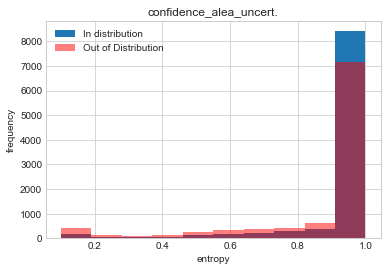

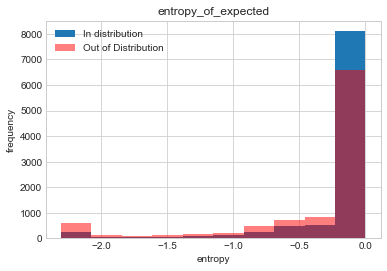

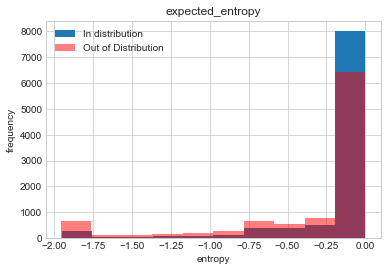

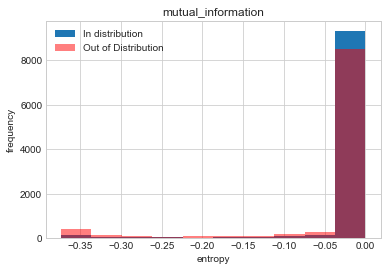

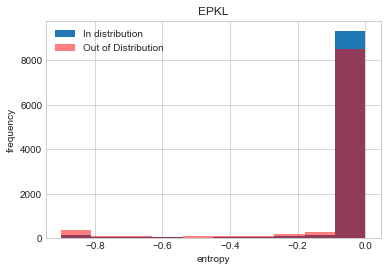

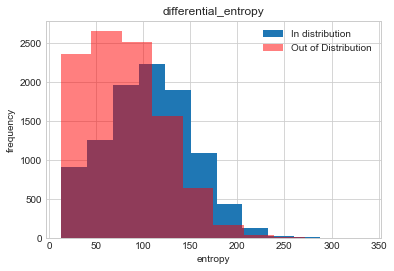

In [78]:
buildOutlierPlot_energy(outputs_test,outputs100)

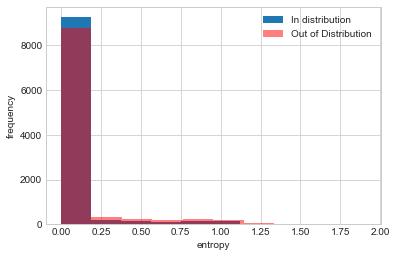

OOD accepted with avg ID entropy threshold of  0.051234607 :  8231 out of  9984
ID accepted with avg ID entropy threshold of  0.051234607 :  8968 out of  9984 with acc of  0.6952497769848349
overall acc on ID: 0.65625


In [172]:
buildOutlierPlot(outputs_test, outputs100, 0.051234607)

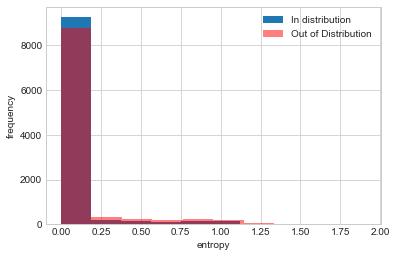

OOD accepted with avg ID entropy threshold of  0.4392441 :  9156 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  9494 out of  9984 with acc of  0.6754792500526648
overall acc on ID: 0.65625


(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 100), dtype=tf.float32, name=None))>


      x  y    uncert correct
4     4  6  0.930254       0
5     5  6  3.623051       0
6     9  1  1.296380       0
7     6  6  2.699459       1
11    9  9  0.004538       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9978  4  7  0.796550       0
9981  4  4  2.363454       1

[5065 rows x 4 columns]
      x  y    uncert correct
0     3  3  9.289042       1
3     0  0  9.048504       1
7     6  6  2.699459       1
8     3  3  7.678715       1
9     1  1  6.884835       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9979  3  3  8.626763       1
9981  4  4  2.363454       1

[6483 rows x 4 columns]


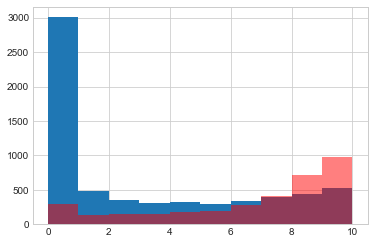

In [117]:
threshold = 4.39244132
accepted = outputs.loc[(outputs['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs.loc[(outputs['correct'] == True)]
Incorrect = outputs.loc[(outputs['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

In [130]:

outputs100 = getPredictions(model,test_ds100)
print(outputs100)

[0.23711371 0.67648697 0.85404116 ... 0.7878681  0.66152674 0.10553702]
avg entropy 0.66300267
      x   y    uncert correct
0     0  49  0.237114       0
1     4  33  0.676487       0
2     4  72  0.854041       0
3     1  51  0.115120       0
4     1  71  0.842340       0
...  ..  ..       ...     ...
9979  3  27  0.366997       0
9980  8  30  0.636400       0
9981  9  52  0.787868       0
9982  6  74  0.661527       0
9983  6  29  0.105537       0

[9984 rows x 4 columns]


      x   y    uncert correct
0     0  49  0.237114       0
3     1  51  0.115120       0
6     4  15  0.370688       0
9     7   0  0.156786       0
10    3  71  0.411594       0
...  ..  ..       ...     ...
9970  6  18  0.008494       0
9972  8  26  0.239801       0
9974  8  11  0.308005       0
9979  3  27  0.366997       0
9983  6  29  0.105537       0

[2403 rows x 4 columns]
      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


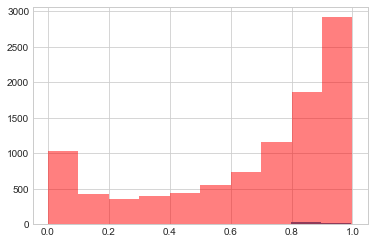

In [131]:
threshold = 0.4392441
accepted = outputs100.loc[(outputs100['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs100.loc[(outputs100['correct'] == True)]
Incorrect = outputs100.loc[(outputs100['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


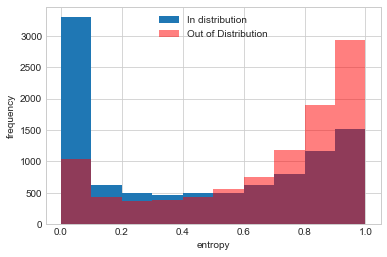

OOD accepted with avg ID entropy threshold of  0.4392441 :  2403 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  5065 out of  9984 with acc of  0.8452122408687068


In [140]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test, outputs100, 0.4392441)

In [142]:
Correct = outputs_test.loc[(outputs_test['correct'] == True)]
Incorrect = outputs_test.loc[(outputs_test['correct'] == False)]
print(len(Correct)/len(outputs_test))

0.6493389423076923


In [152]:
def entropyMetric_old():
    def entropy(p, y_hat):
        #METRIC OF THE mean of uncertainity
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies
    return entropy

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric_old()])

history = model.fit(train_ds, epochs=10)

Epoch 1/10
1406/1406 [==============================] - 7s 4ms/step - loss: 1.7714 - accuracy: 0.3800 - entropy: -269.5092
Epoch 2/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.3332 - accuracy: 0.5236 - entropy: -547.2267
Epoch 3/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.1859 - accuracy: 0.5852 - entropy: -793.7892
Epoch 4/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.0911 - accuracy: 0.6173 - entropy: -1051.1556
Epoch 5/10
1406/1406 [==============================] - 6s 5ms/step - loss: 1.0100 - accuracy: 0.6464 - entropy: -1337.5408
Epoch 6/10
1406/1406 [==============================] - 7s 5ms/step - loss: 0.9382 - accuracy: 0.6712 - entropy: -1744.2469
Epoch 7/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8893 - accuracy: 0.6900 - entropy: -2221.8240
Epoch 8/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8389 - accuracy: 0.7068 - entropy: -2834.1406
Epoch 9/10


In [155]:
import math
num_classes=10
def getPredictions(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            y_hat =tf.nn.softmax(prediction)
            val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
            u =  -tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

outputs_test2 = getPredictions(model,test_ds)
print(outputs_test2)
# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))
model.evaluate(test_ds)


[2.9127266  0.28847754 1.7646978  ... 1.5443833  2.1113863  0.4810803 ]
avg entropy 1.0540112
      x  y    uncert correct
0     8  3  2.912727       0
1     8  8  0.288478       1
2     0  8  1.764698       0
3     0  0  0.412173       1
4     6  6  1.835032       1
...  .. ..       ...     ...
9979  3  3  0.222059       1
9980  0  0  0.102112       1
9981  7  4  1.544383       0
9982  3  2  2.111386       0
9983  1  0  0.481080       0

[9984 rows x 4 columns]


In [156]:
outputs100_2 = getPredictions(model,test_ds100)
print(outputs100_2)

[0.7781605 2.2761638 1.5880288 ... 0.7205749 2.28415   1.5985643]
avg entropy 1.5279474
      x   y    uncert correct
0     2  49  0.778161       0
1     4  33  2.276164       0
2     0  72  1.588029       0
3     9  51  1.273938       0
4     8  71  2.651380       0
...  ..  ..       ...     ...
9979  2  27  0.562674       0
9980  0  30  1.932048       0
9981  7  52  0.720575       0
9982  5  74  2.284150       0
9983  2  29  1.598564       0

[9984 rows x 4 columns]


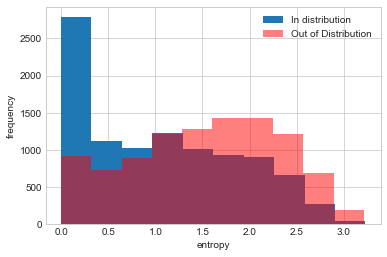

OOD accepted with avg ID entropy threshold of  1.5279474 :  4726 out of  9984
ID accepted with avg ID entropy threshold of  1.5279474 :  6876 out of  9984 with acc of  0.7232402559627691
overall acc on ID: 0.6126802884615384


In [161]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test2, outputs100_2, 1.5279474)

In [165]:
def MAEBM(annealing):
    def loss(labels, outputs):
        # tf.print(outputs)
        evidence = tf.exp(outputs) #activation function
        # tf.print(evidence)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha)
        # tf.print(S)
        alpha_0 = tf.fill(alpha.shape,S)
        UCE_loss = tf.reduce_mean(labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha)))
        # print("loss_1",UCE_loss)
        
        
        UCE_loss  +=  0.0001  * (tf.reduce_sum(tf.compat.v1.lgamma(alpha)) - tf.compat.v1.lgamma(S) -
                (len(alpha) - S) * tf.compat.v1.digamma(S) -
                ((alpha - 1.0) * tf.reduce_sum(tf.compat.v1.digamma(alpha))))
        # tf.print(UCE_loss)
        return UCE_loss
    return loss 
def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

lambda_callback = lambda_update(100)
loss = MAEBM(lambda_callback)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric()])

history = model.fit(train_ds, epochs=10,callbacks=[lambda_callback])


annealing coef updated to: 0
Epoch 1/10
 753/1406 [===============>..............] - ETA: 3s - loss: nan - accuracy: 0.1011 - entropy: nan

KeyboardInterrupt: 